# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

# [作業目標]
- 依照下列提示與引導, 以幾種不同的方式, 檢視可能的離群值

# [作業重點]
- 從原始資料篩選可能的欄位, 看看那些欄位可能有離群值 (In[3], Out[3])
- 繪製目標值累積密度函數(ECDF)的圖形, 和常態分布的累積密度函數對比, 以確認是否有離群值的情形 (In[6], Out[6], In[7], Out[7])

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 設定 data_path
dir_data = '/content/drive/MyDrive/機器學習百日馬拉松/D09_outlier及處理/範例檔案/data'

In [53]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: /content/drive/MyDrive/機器學習百日馬拉松/D09_outlier及處理/範例檔案/data/application_train.csv


KeyError: ignored

In [52]:
## 列出所有特徵的型別
dtype_app_train=app_train.dtypes.reset_index()
dtype_app_train.columns=["Feature","Column_type"]
print(dtype_app_train)
dtype_app_train=dtype_app_train.groupby("Column_type").aggregate('count').reset_index()
dtype_app_train.columns=["Column_type","Number"]
dtype_app_train


                        Feature Column_type
0                    SK_ID_CURR       int64
1                        TARGET       int64
2            NAME_CONTRACT_TYPE      object
3                   CODE_GENDER      object
4                  FLAG_OWN_CAR      object
..                          ...         ...
117   AMT_REQ_CREDIT_BUREAU_DAY     float64
118  AMT_REQ_CREDIT_BUREAU_WEEK     float64
119   AMT_REQ_CREDIT_BUREAU_MON     float64
120   AMT_REQ_CREDIT_BUREAU_QRT     float64
121  AMT_REQ_CREDIT_BUREAU_YEAR     float64

[122 rows x 2 columns]


KeyError: ignored

## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

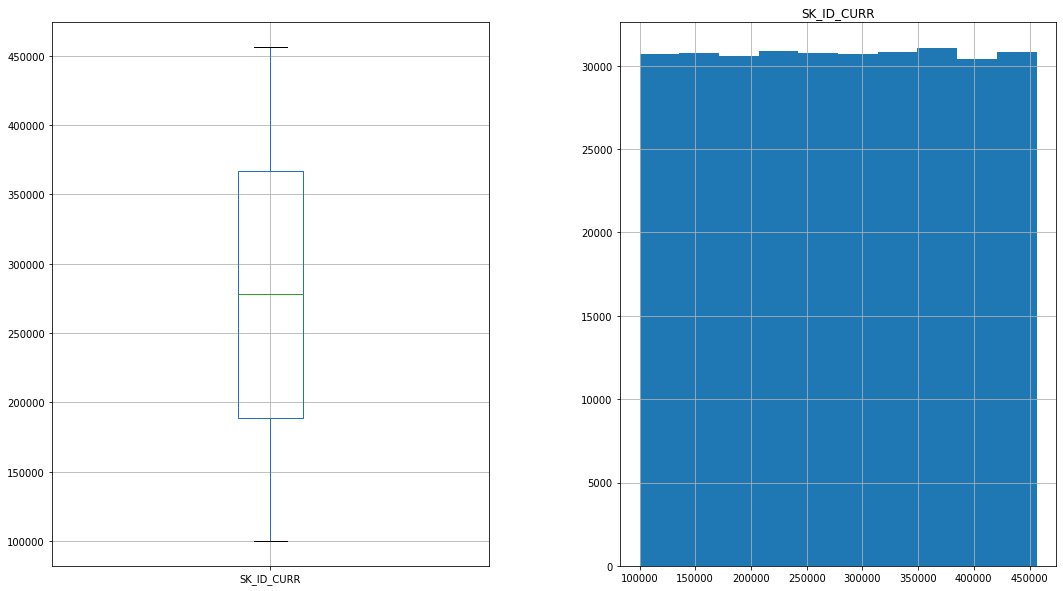

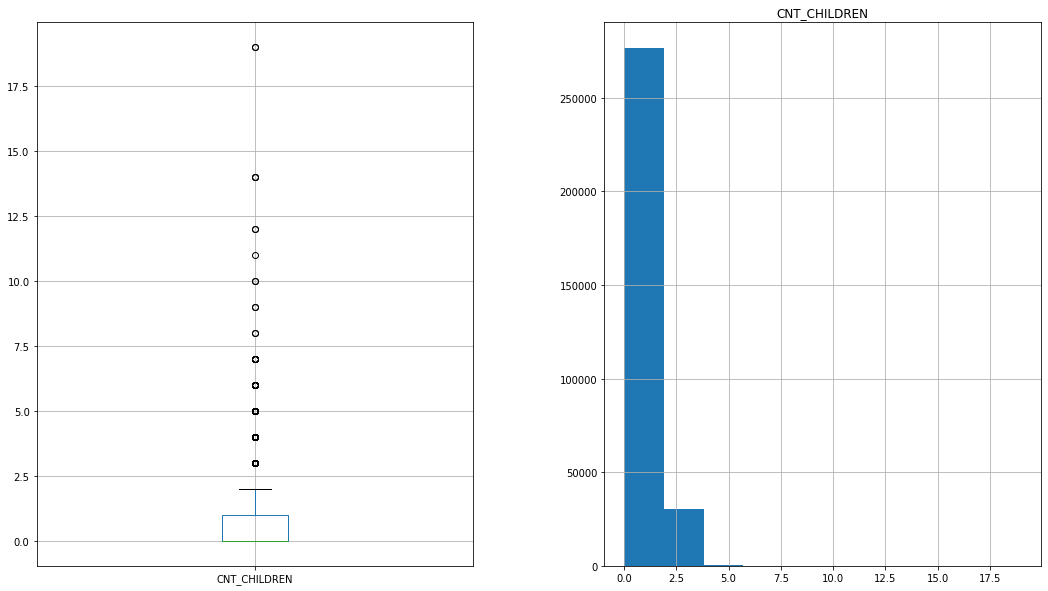

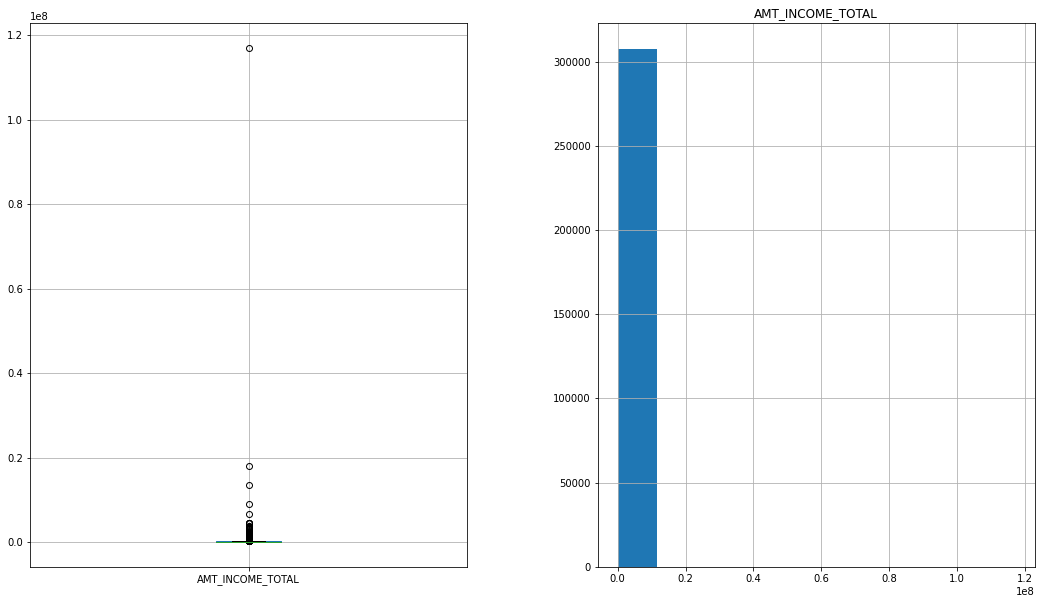

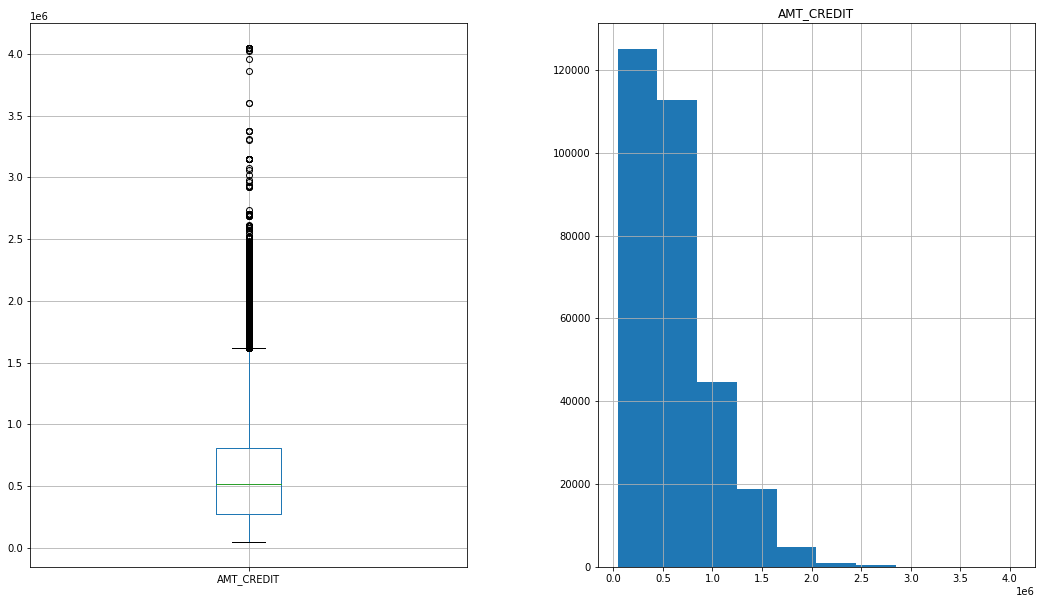

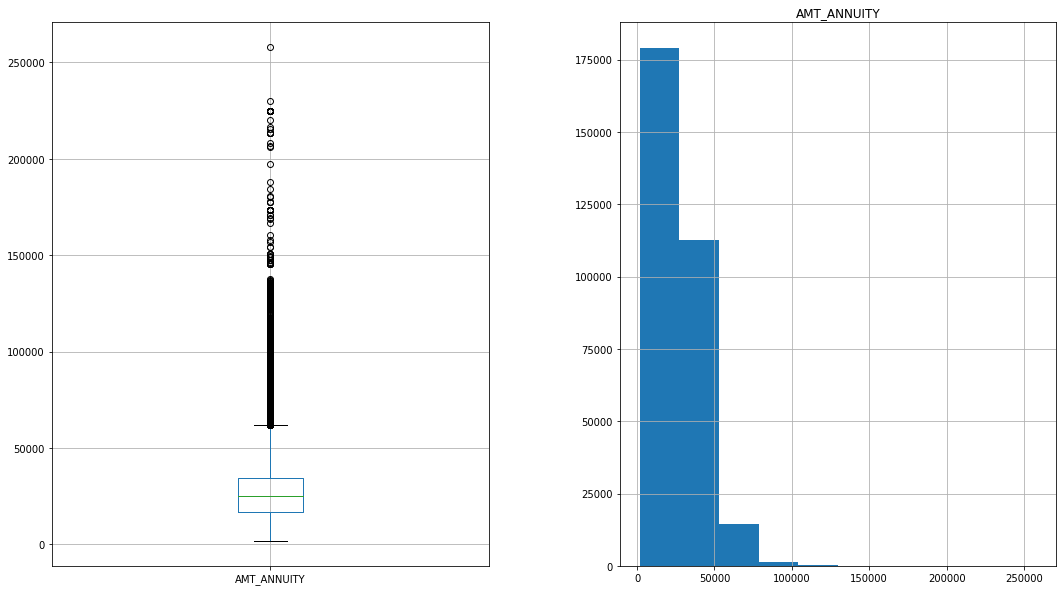

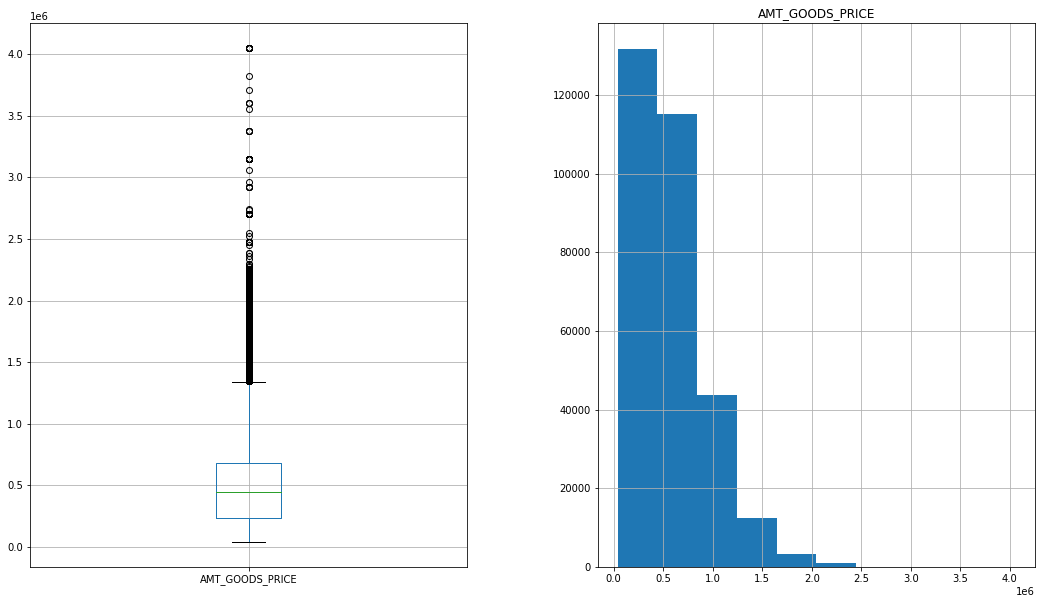

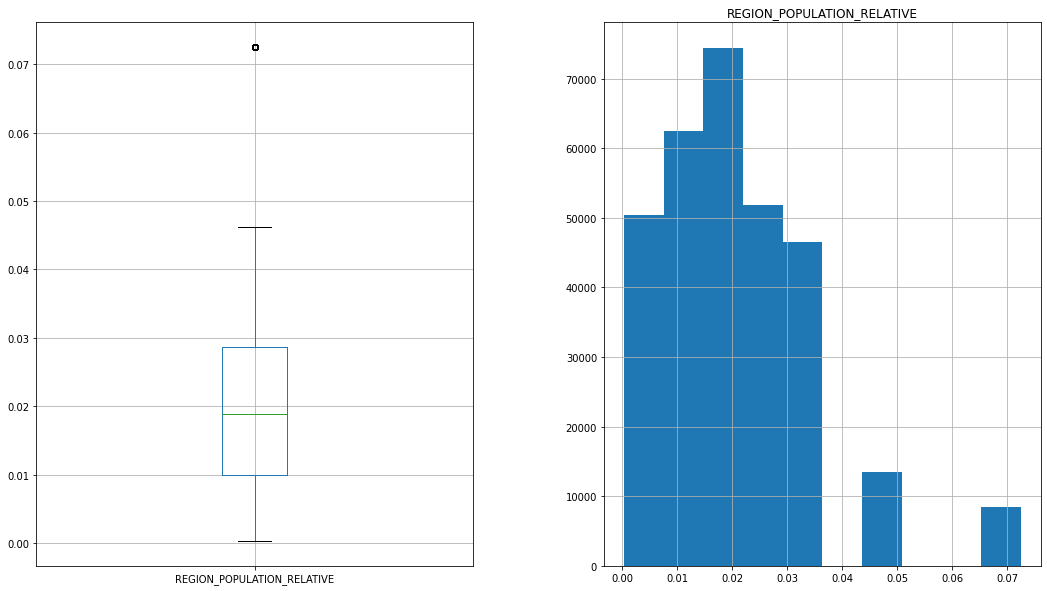

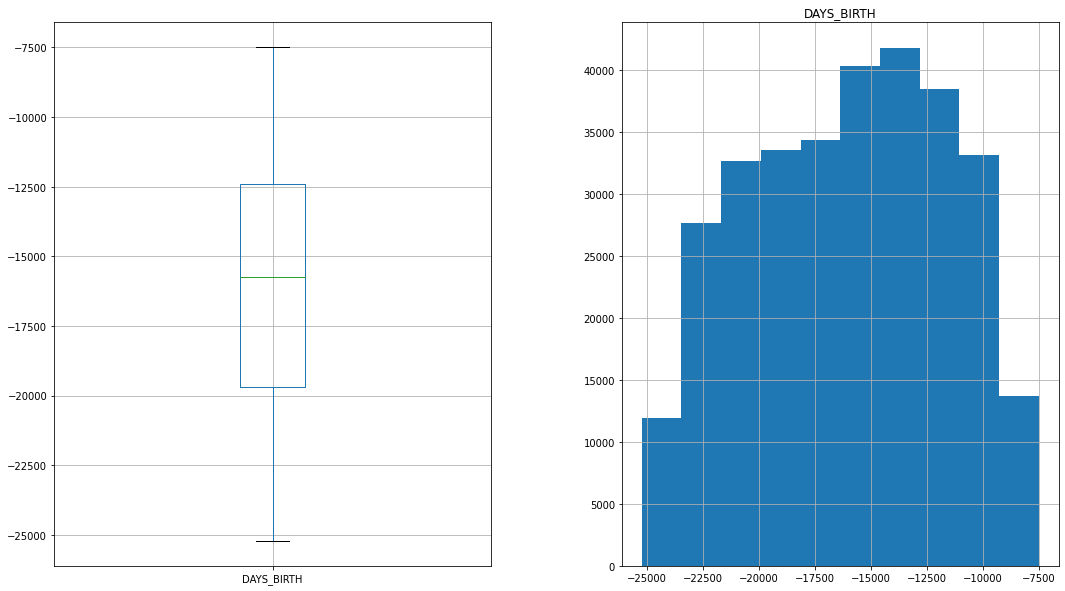

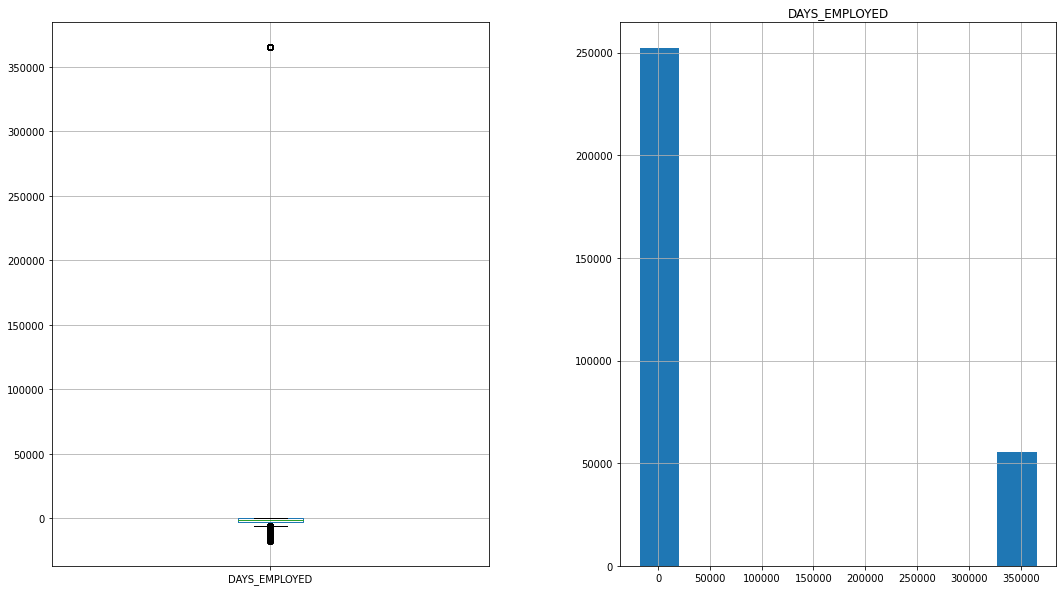

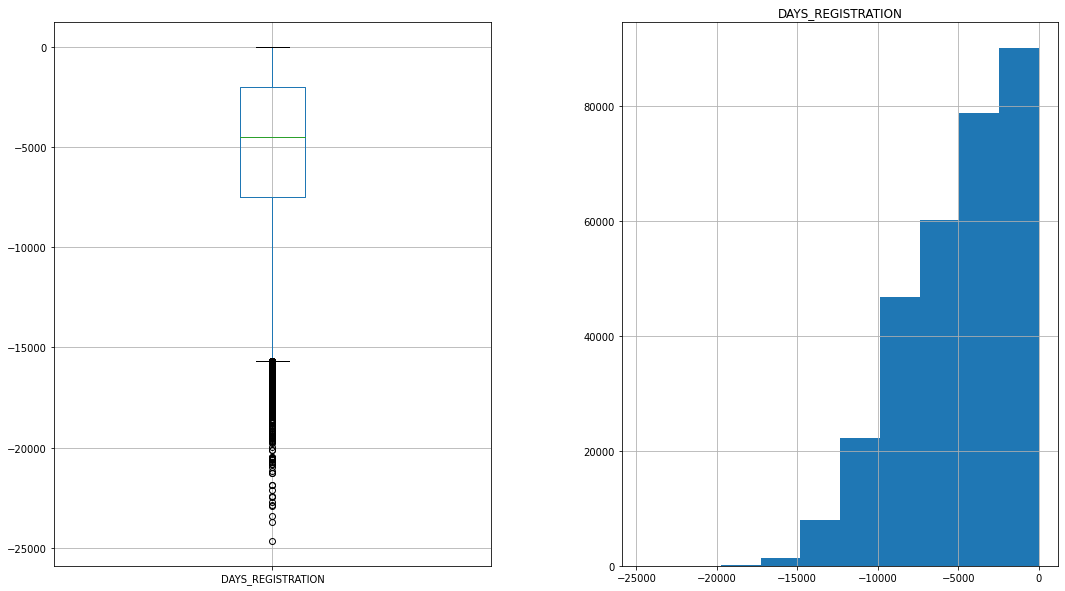

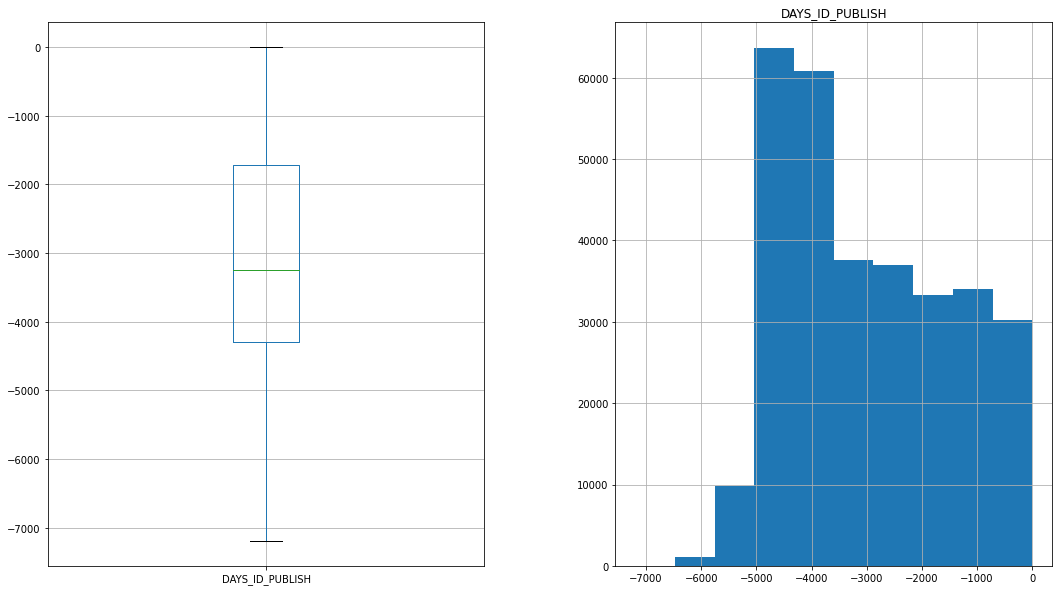

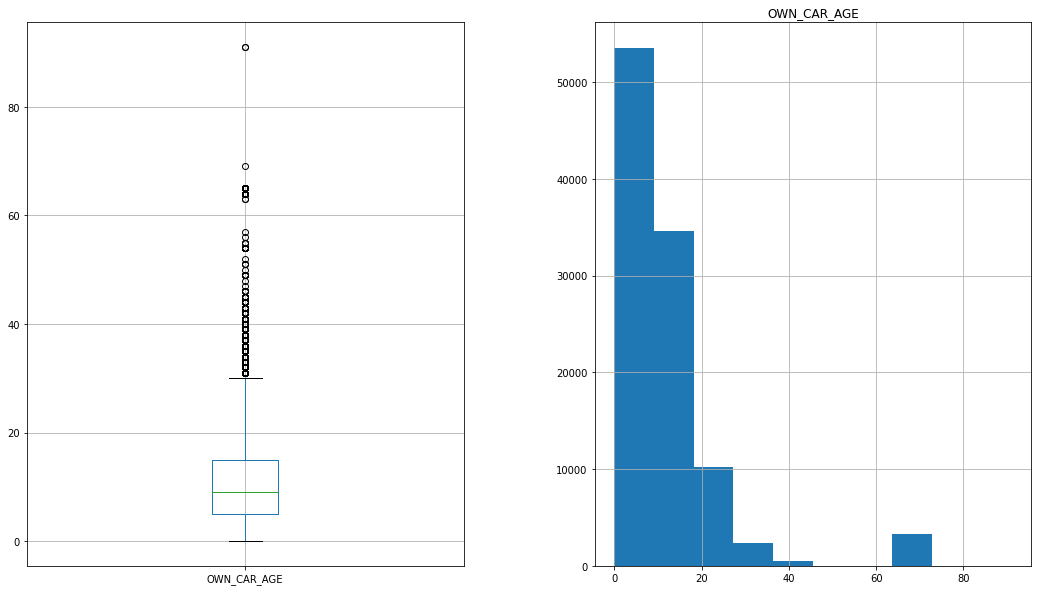

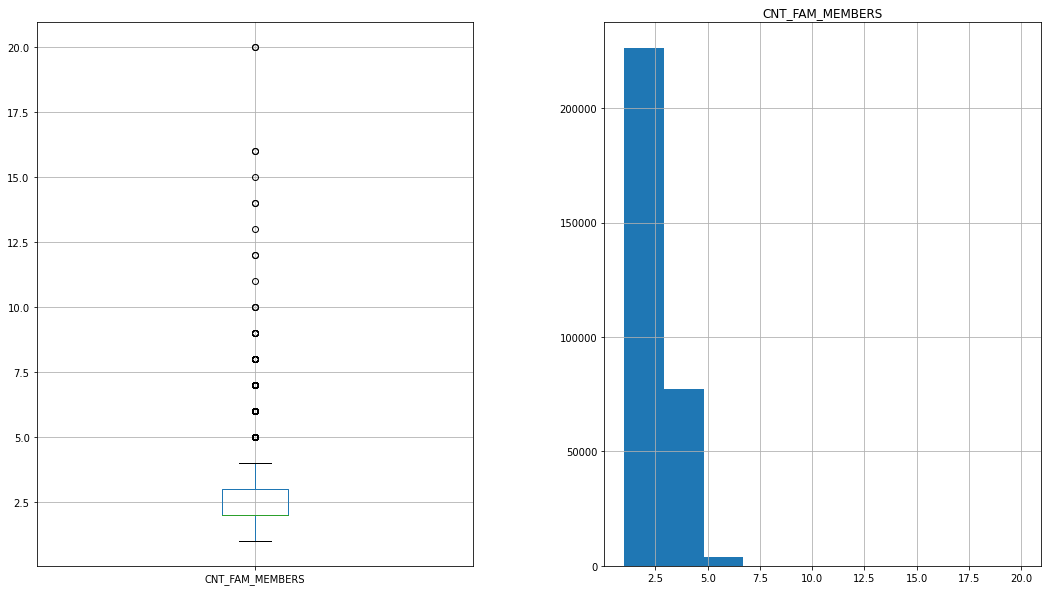

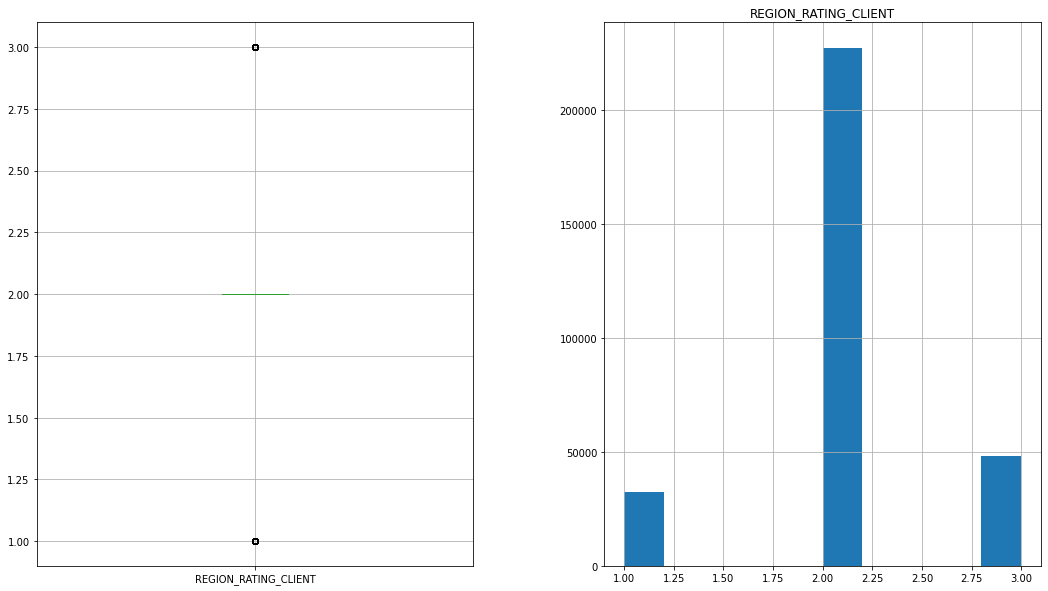

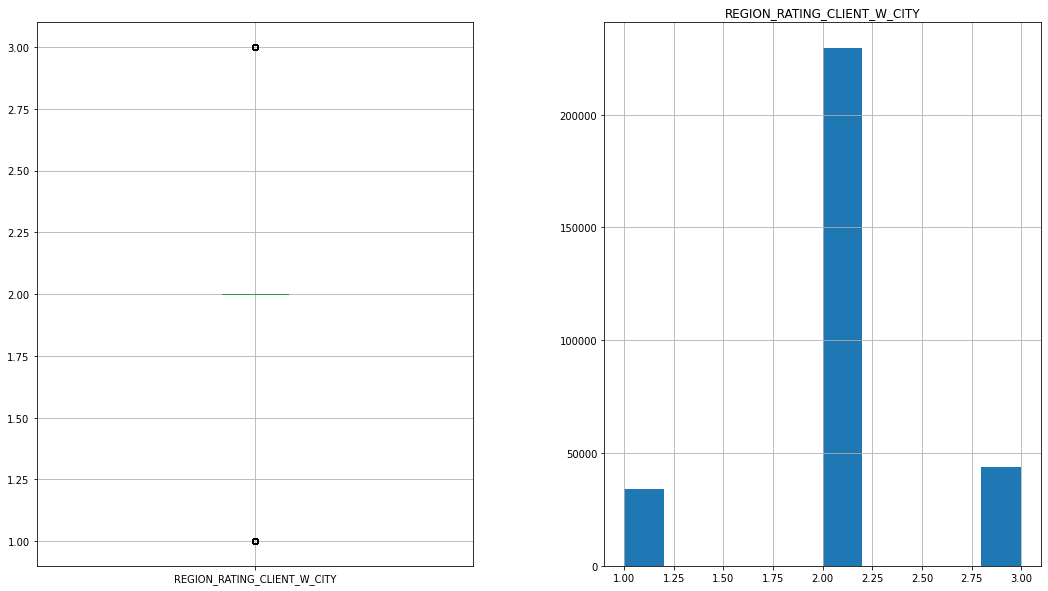

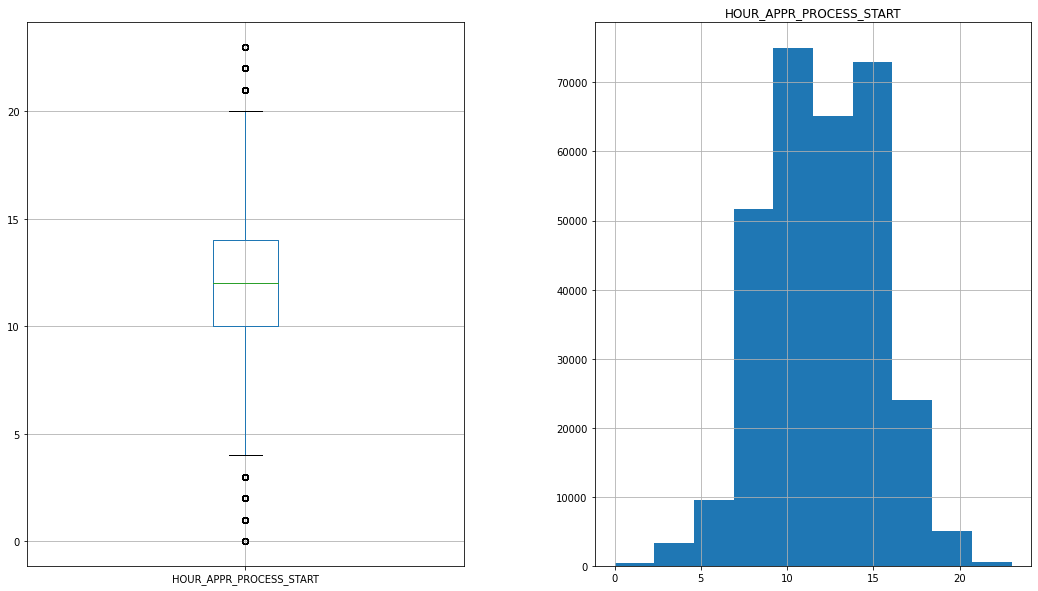

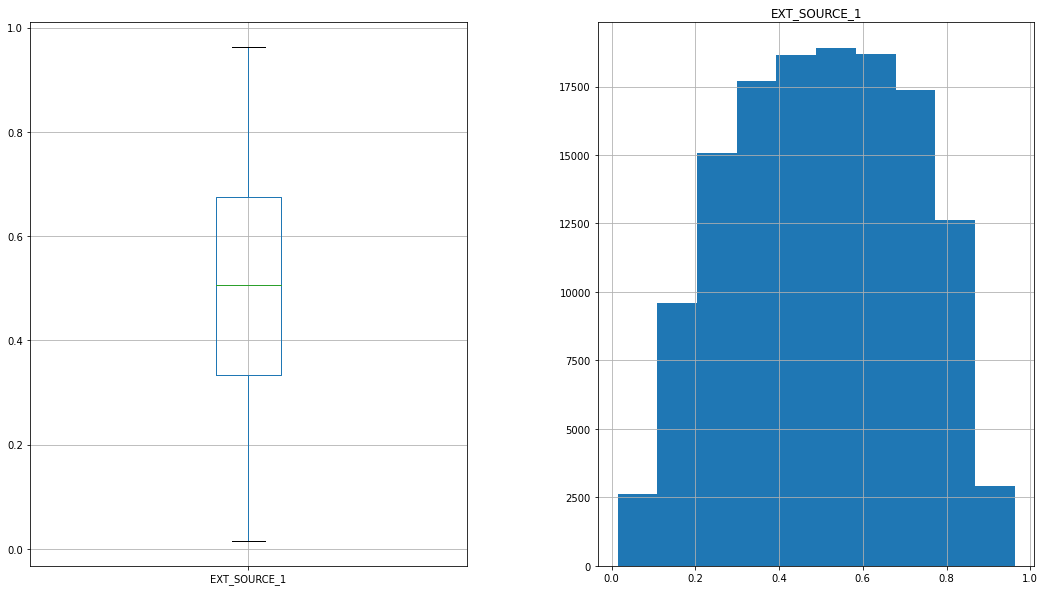

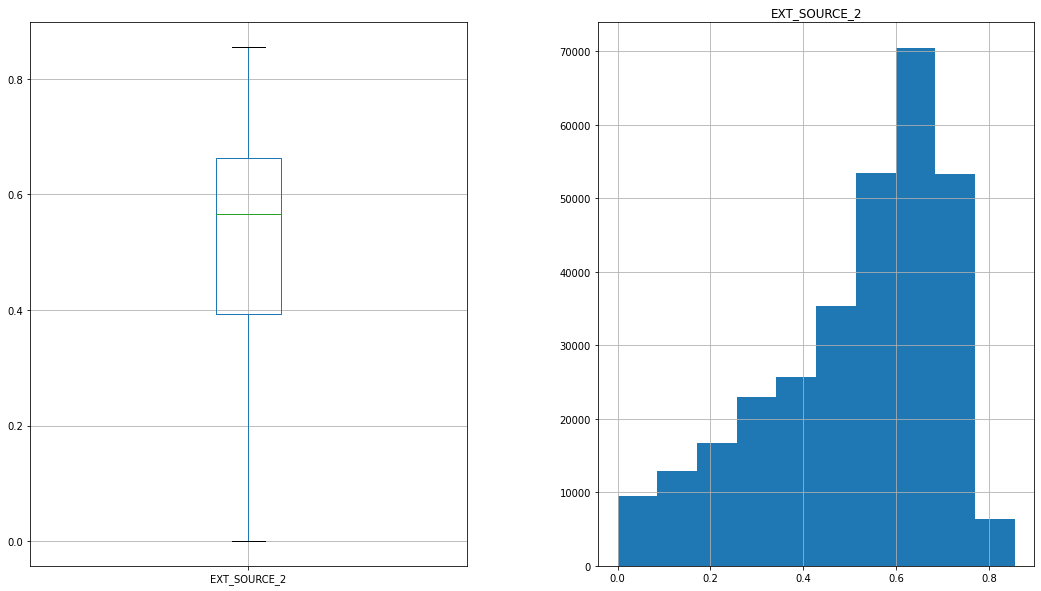

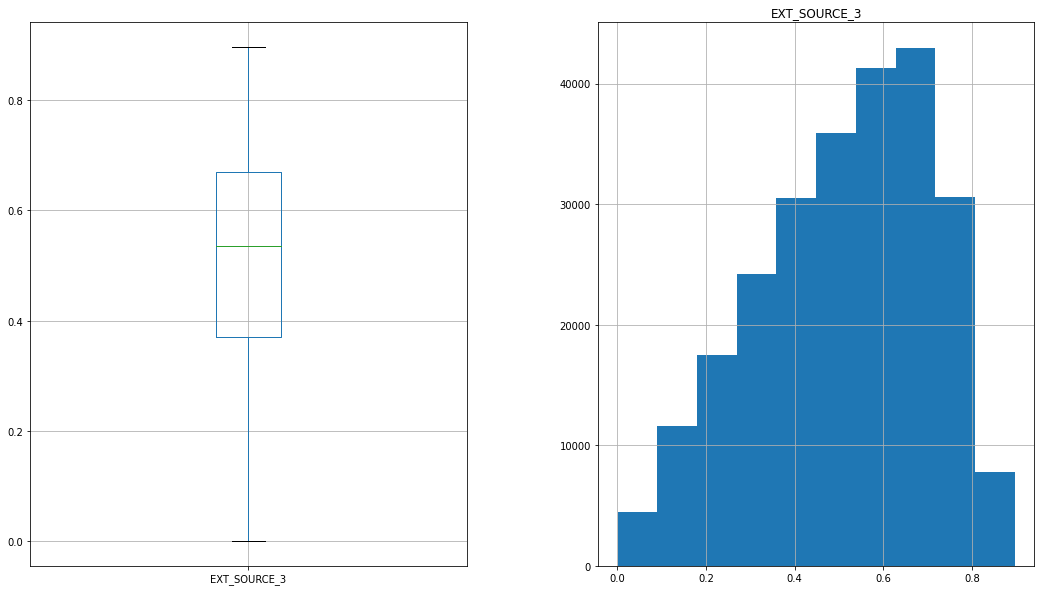

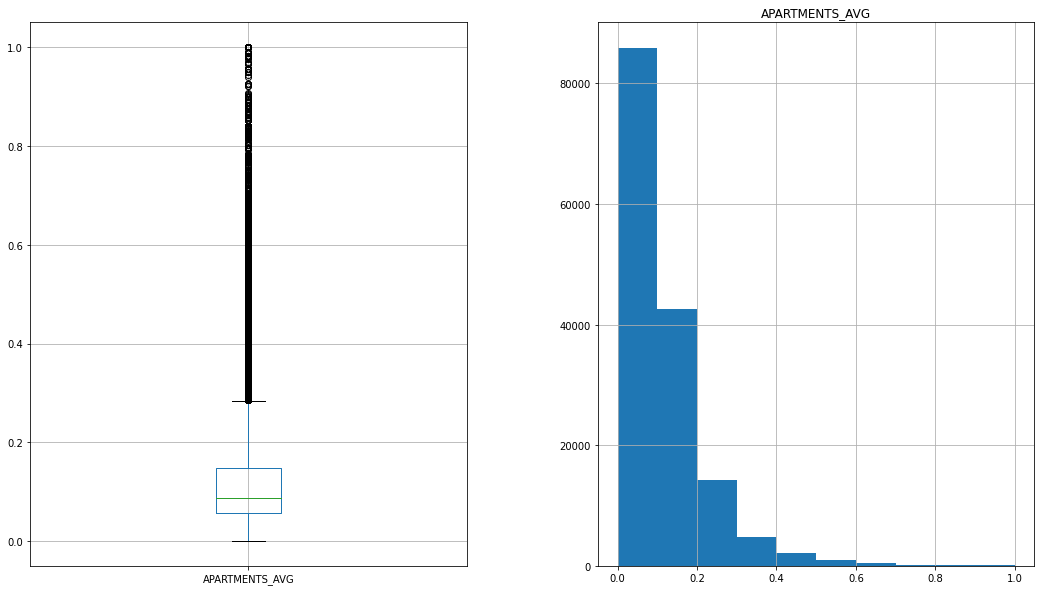

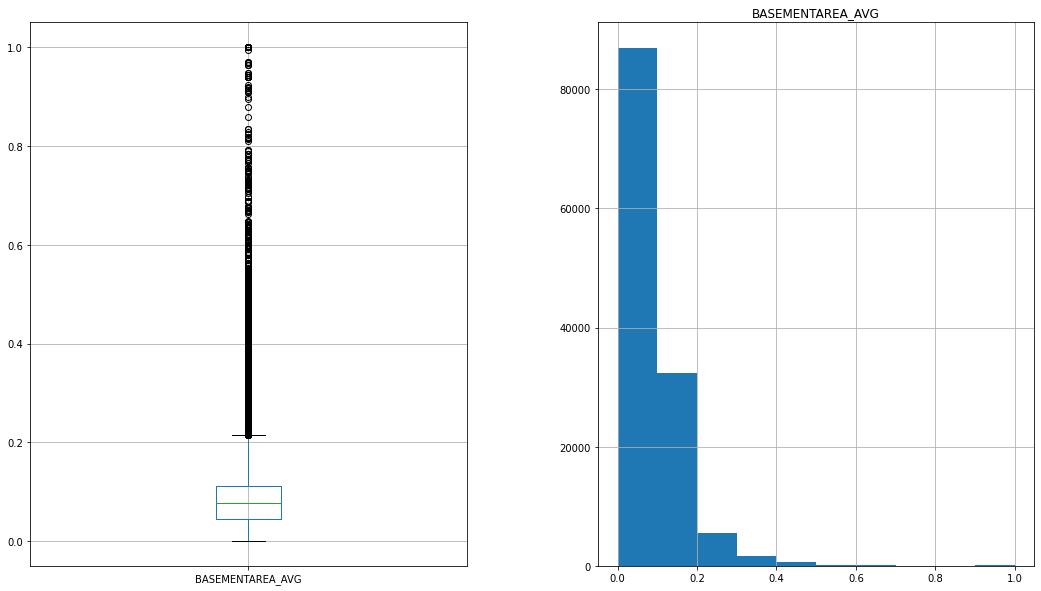

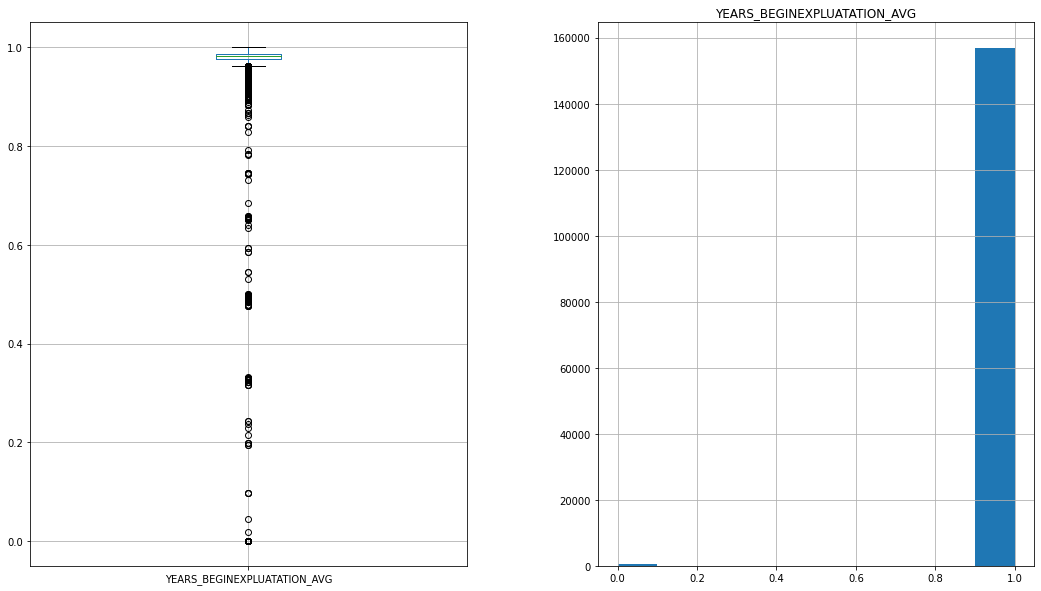

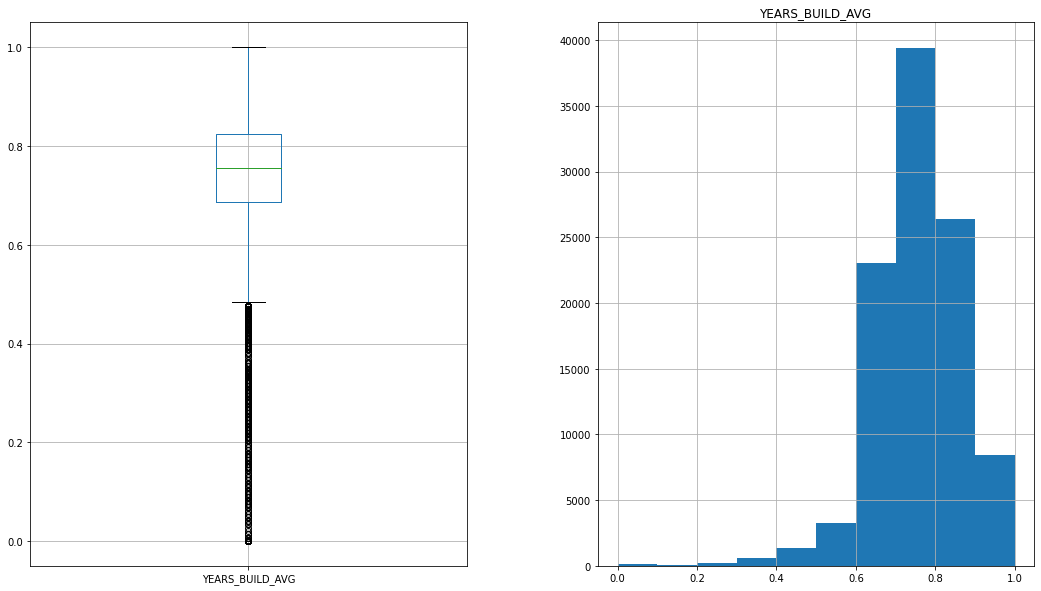

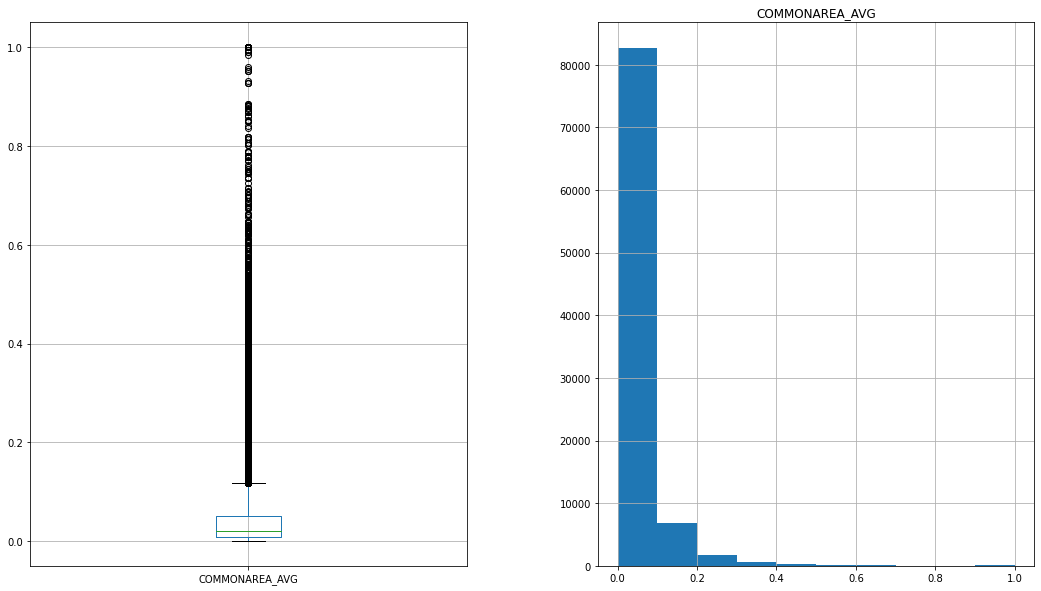

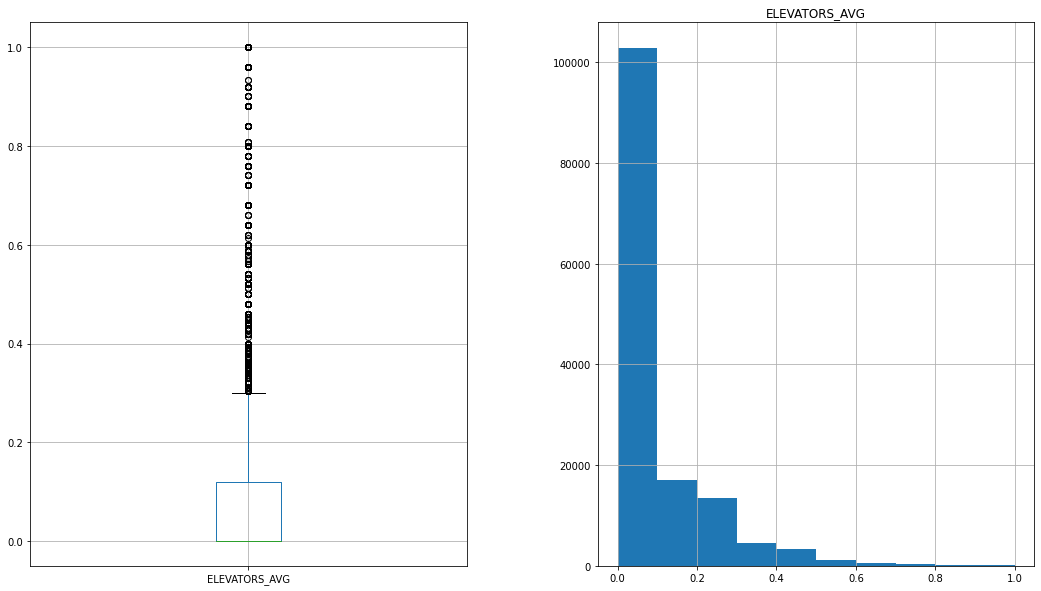

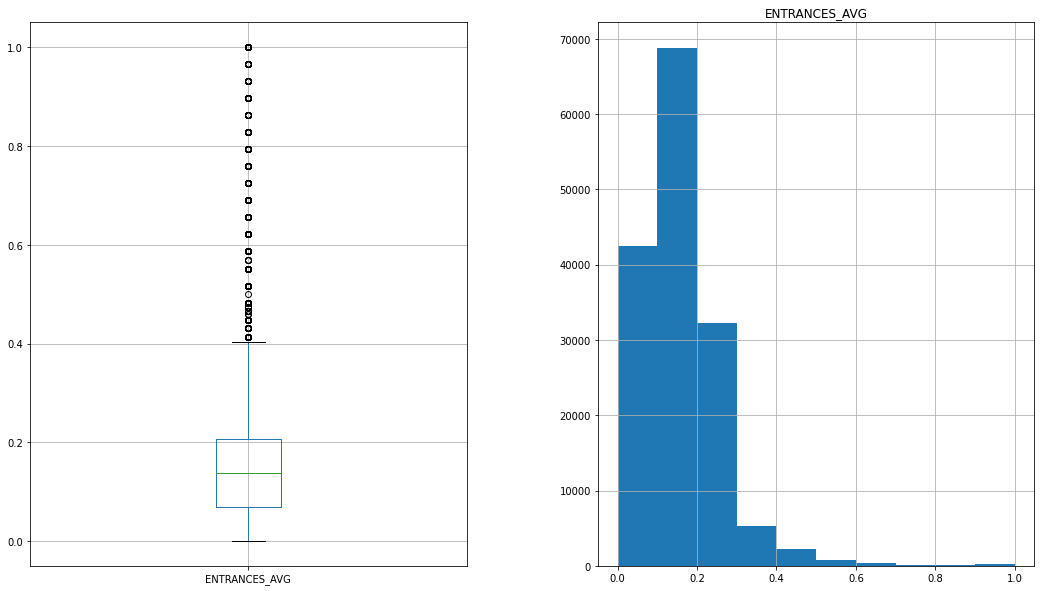

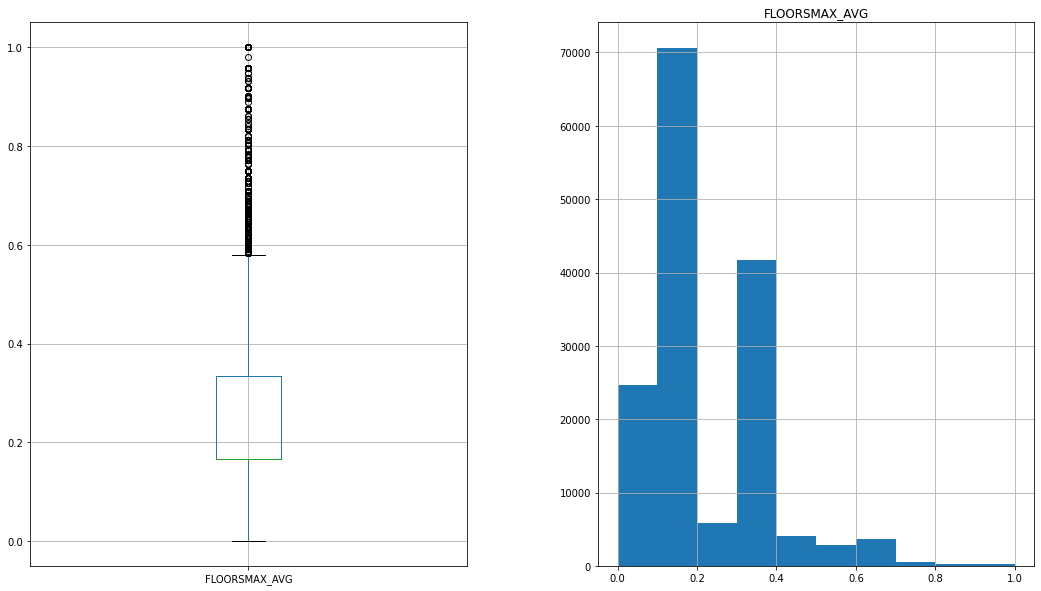

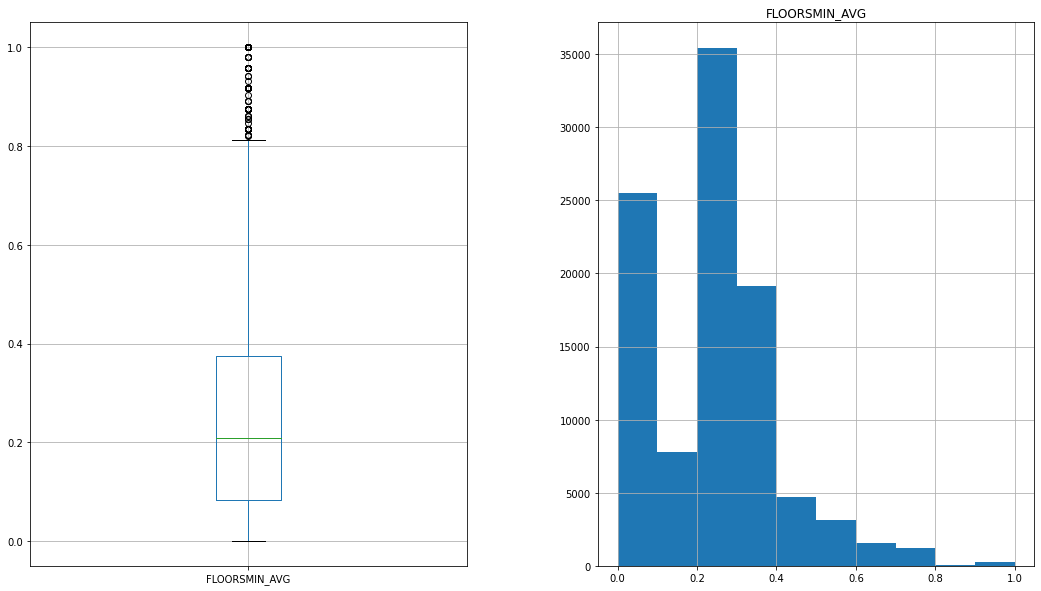

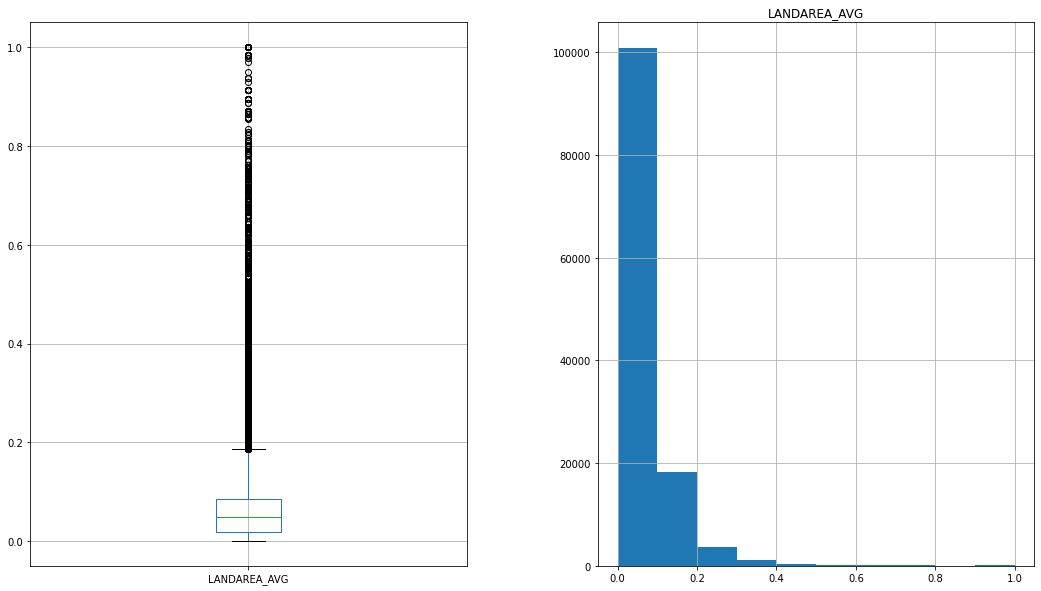

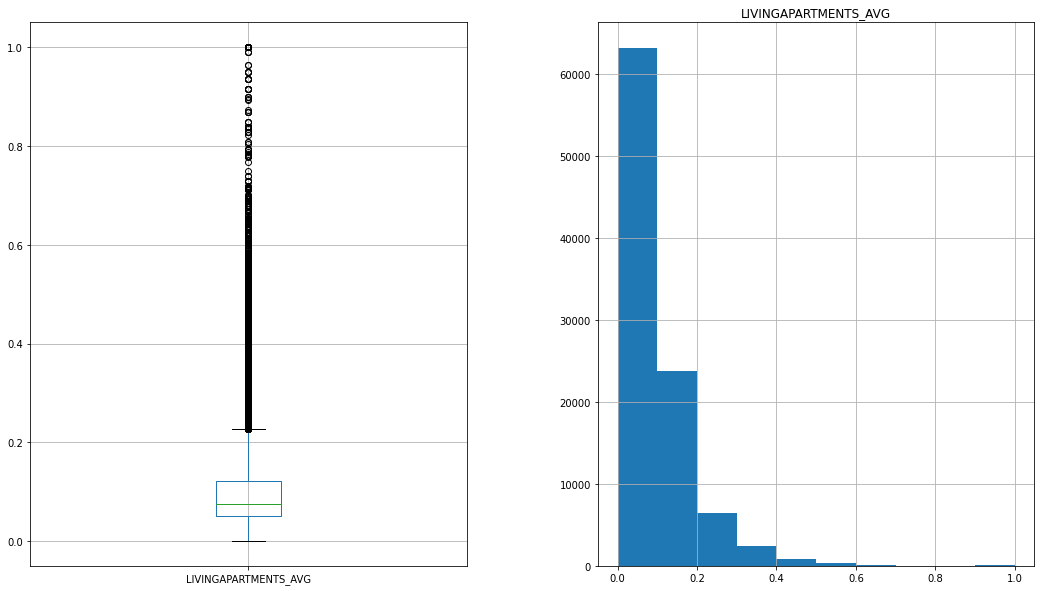

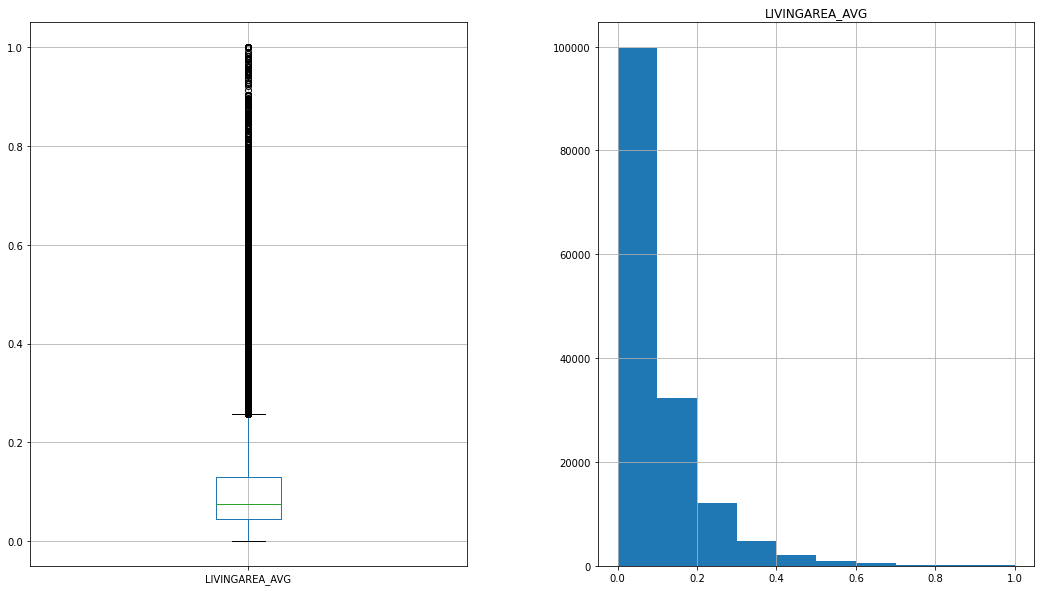

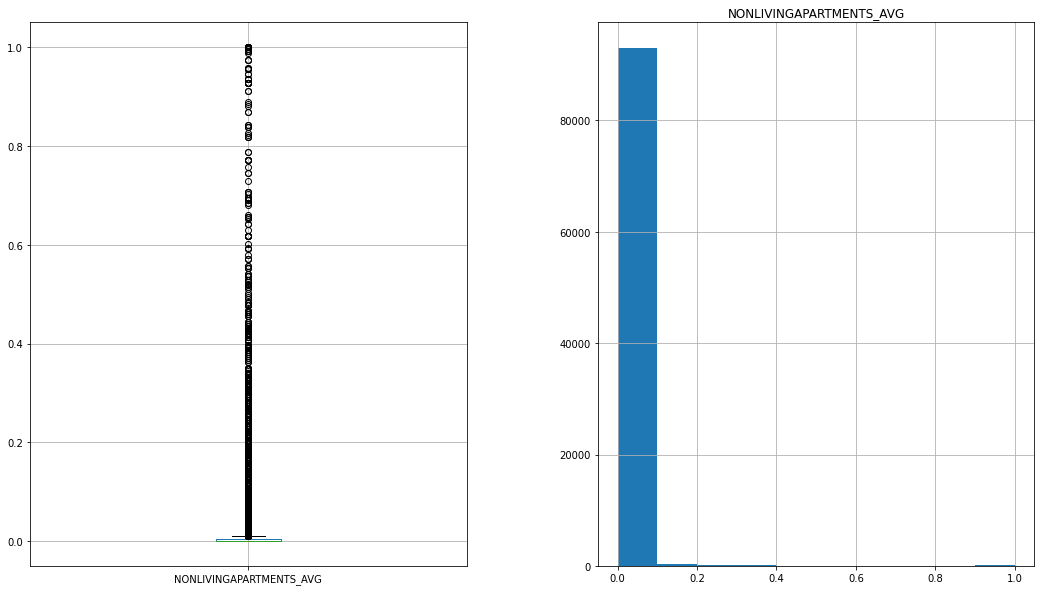

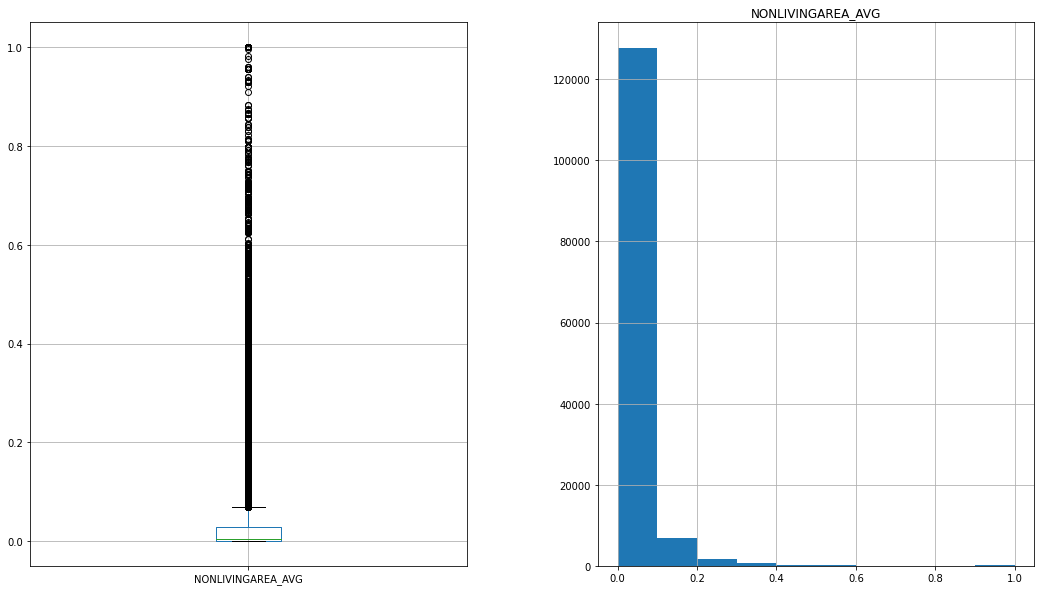

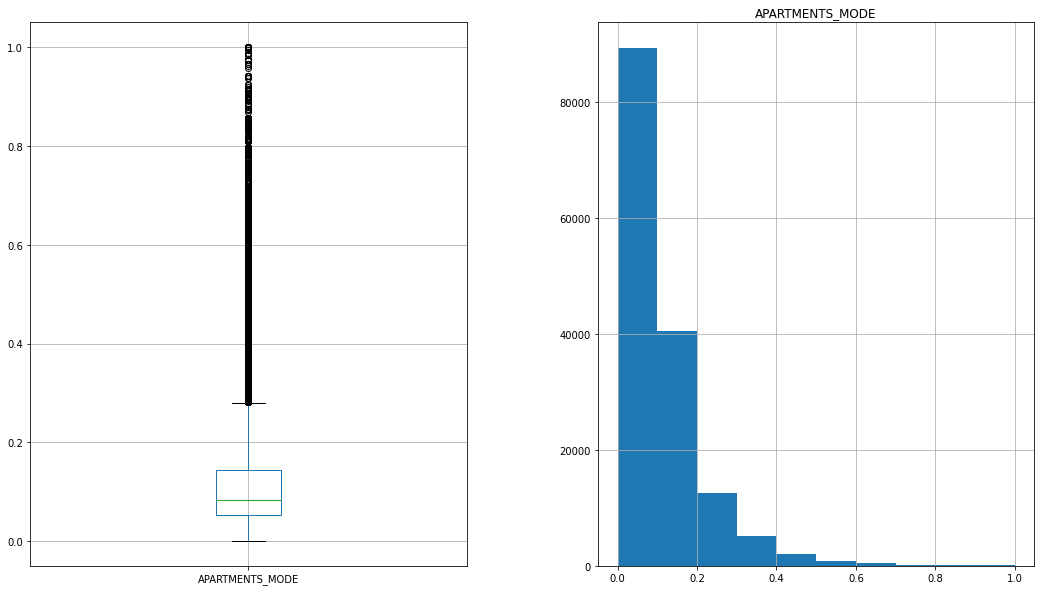

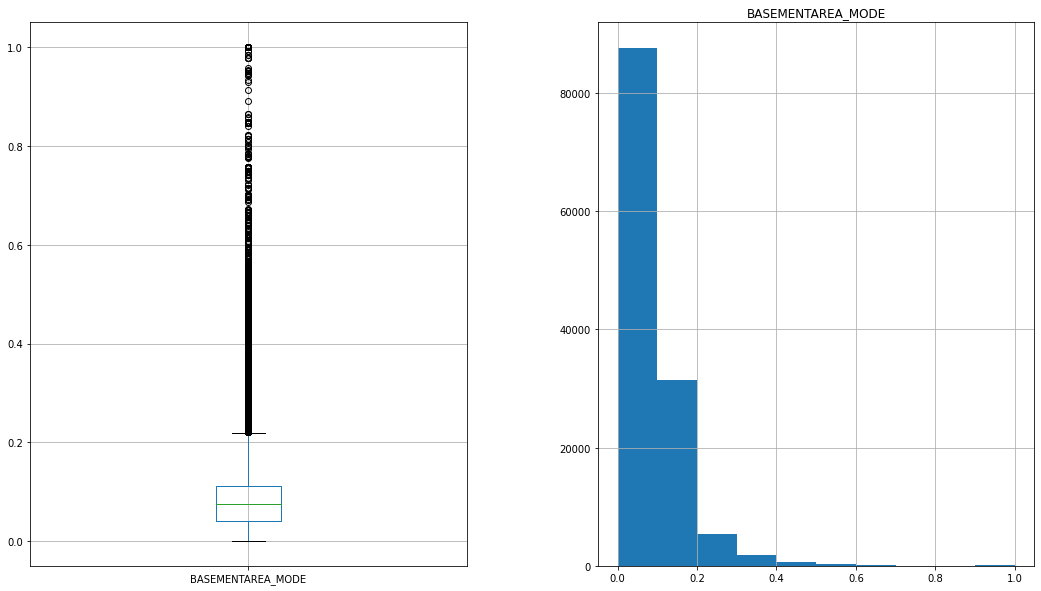

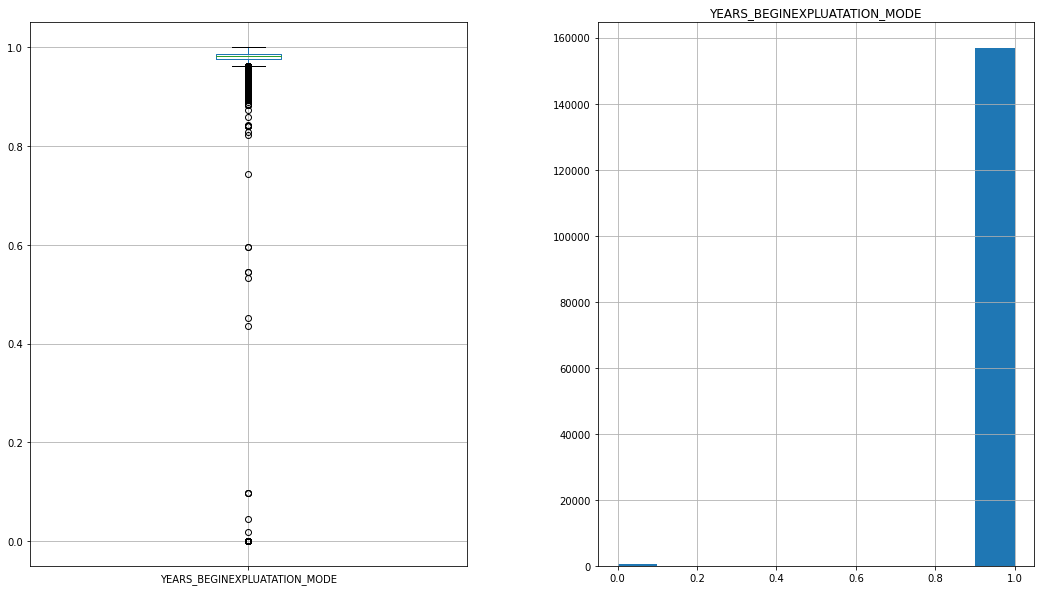

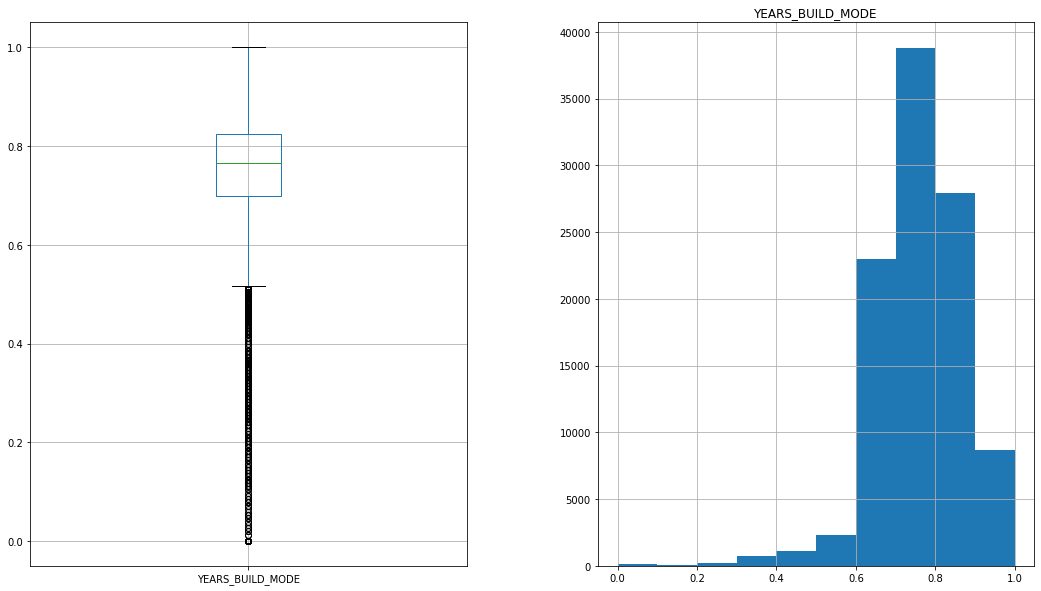

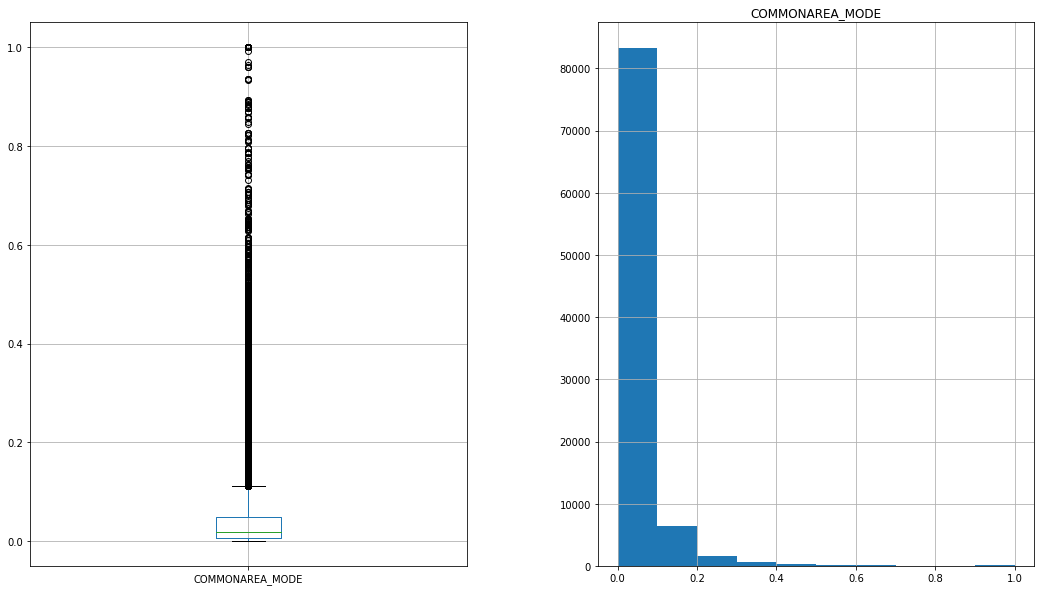

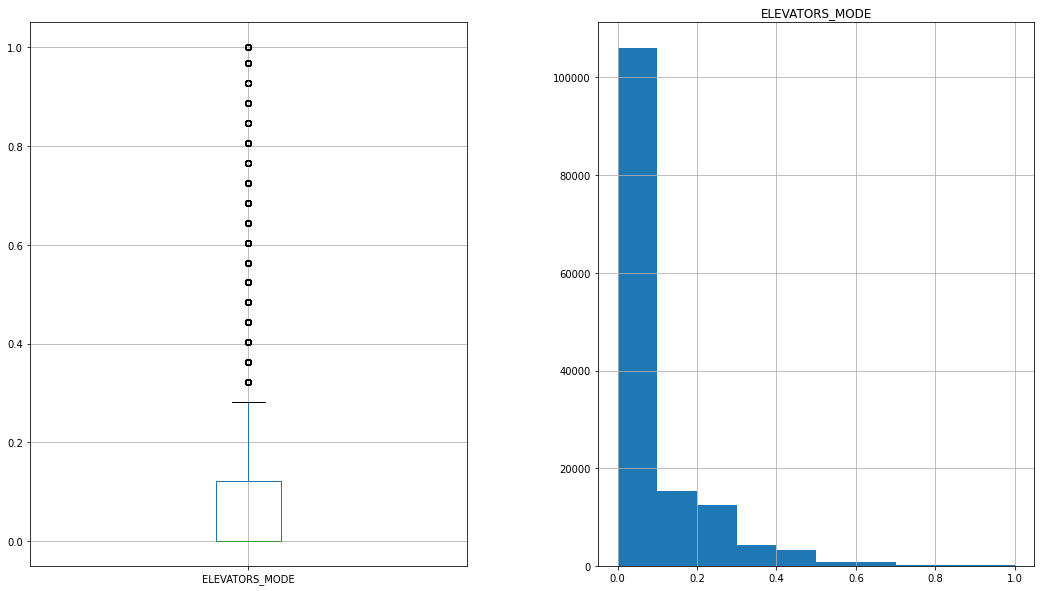

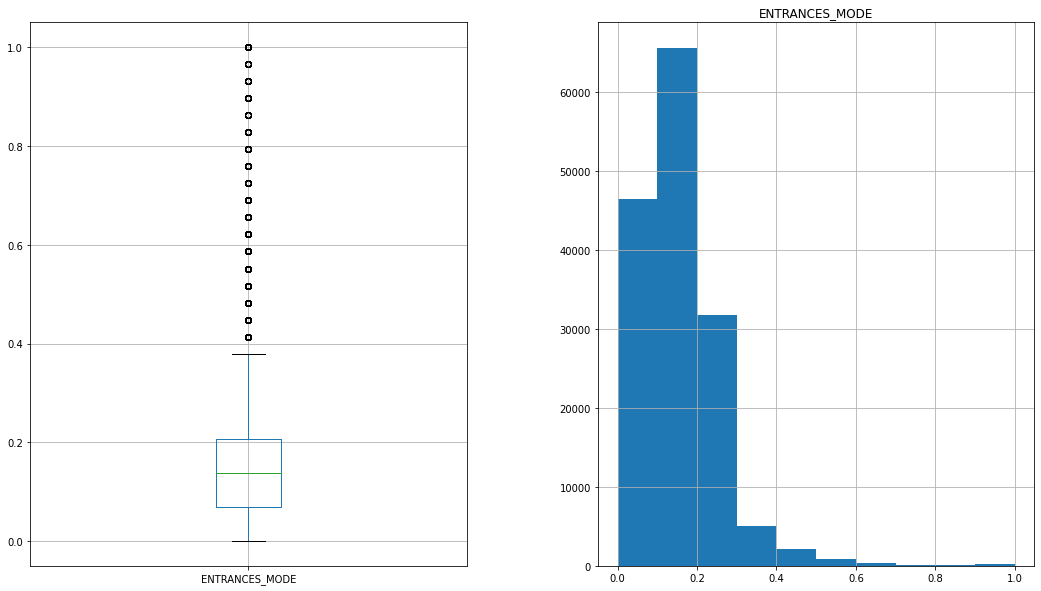

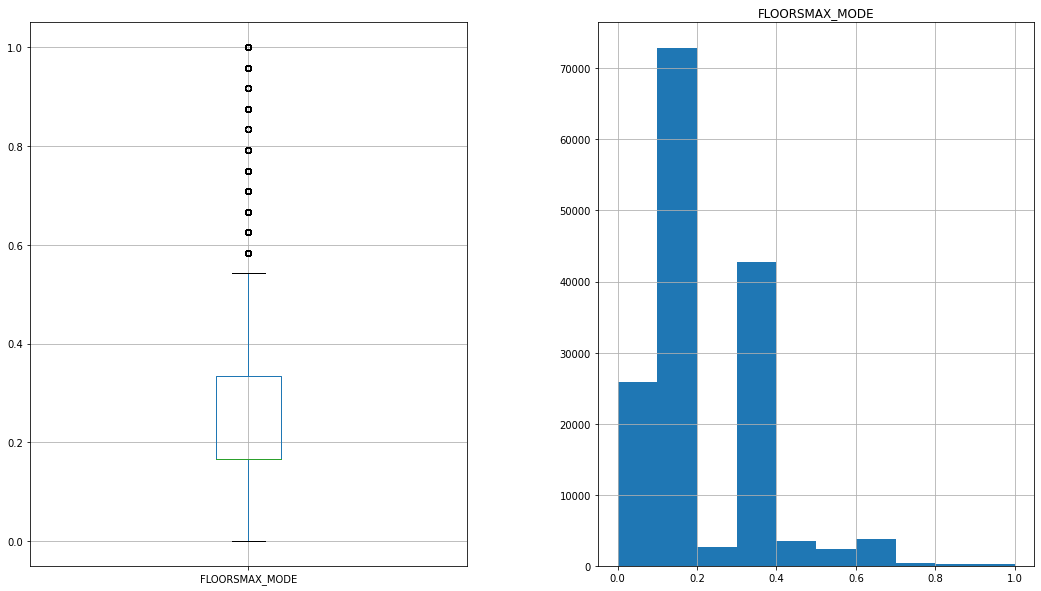

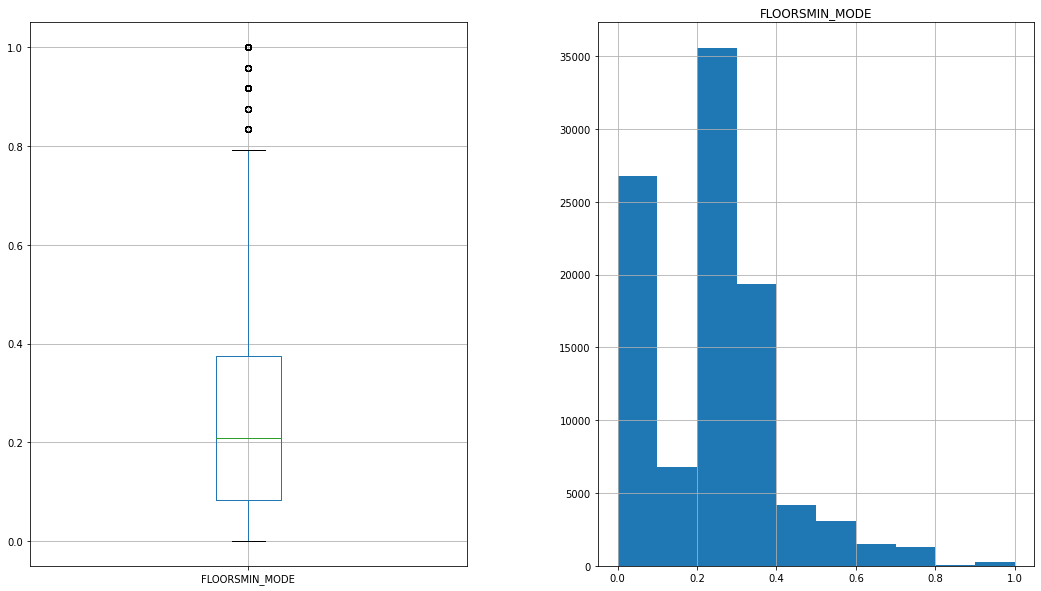

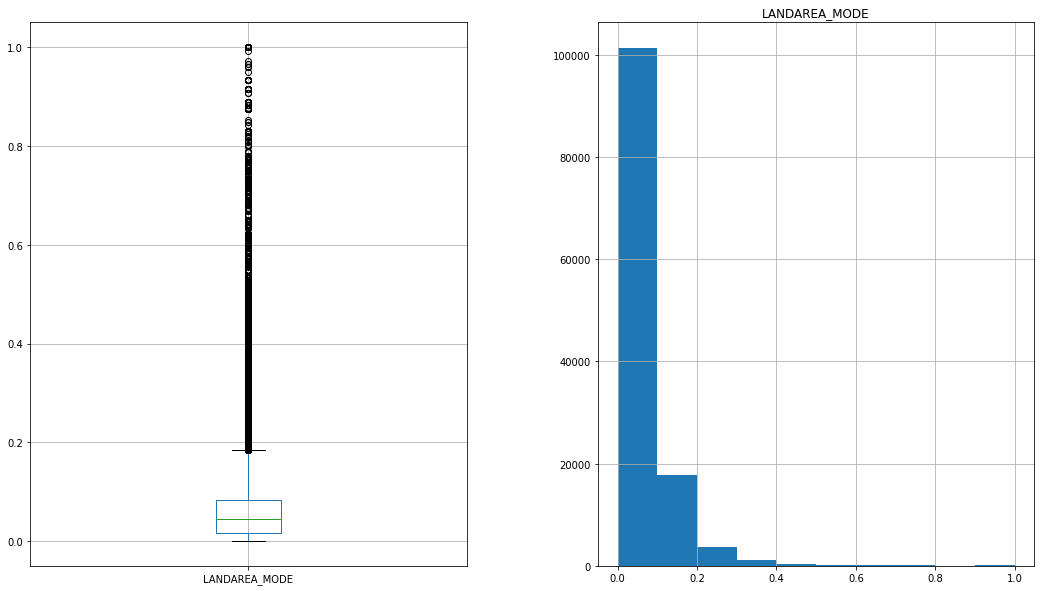

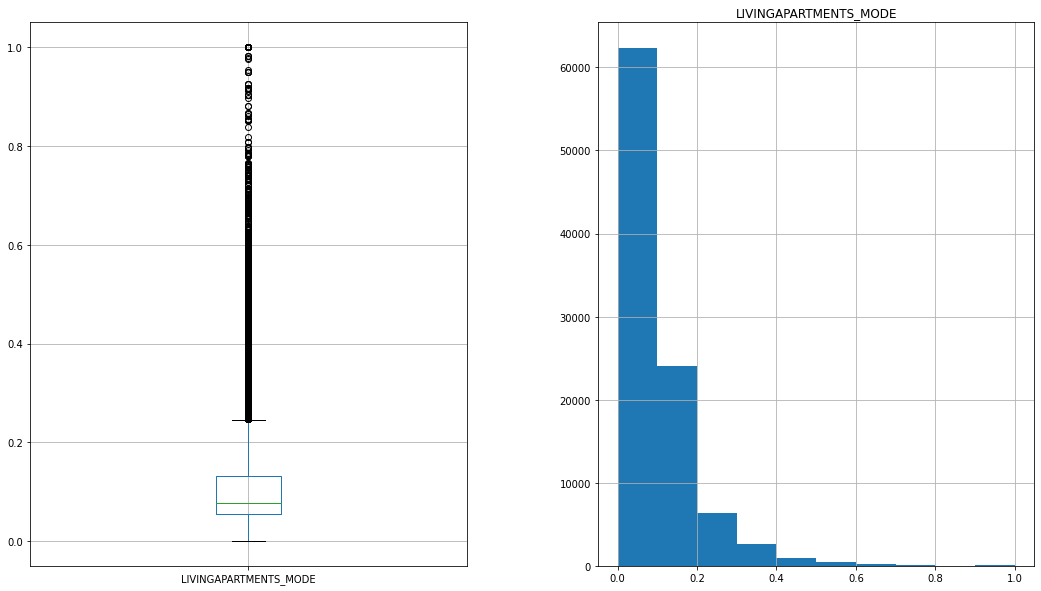

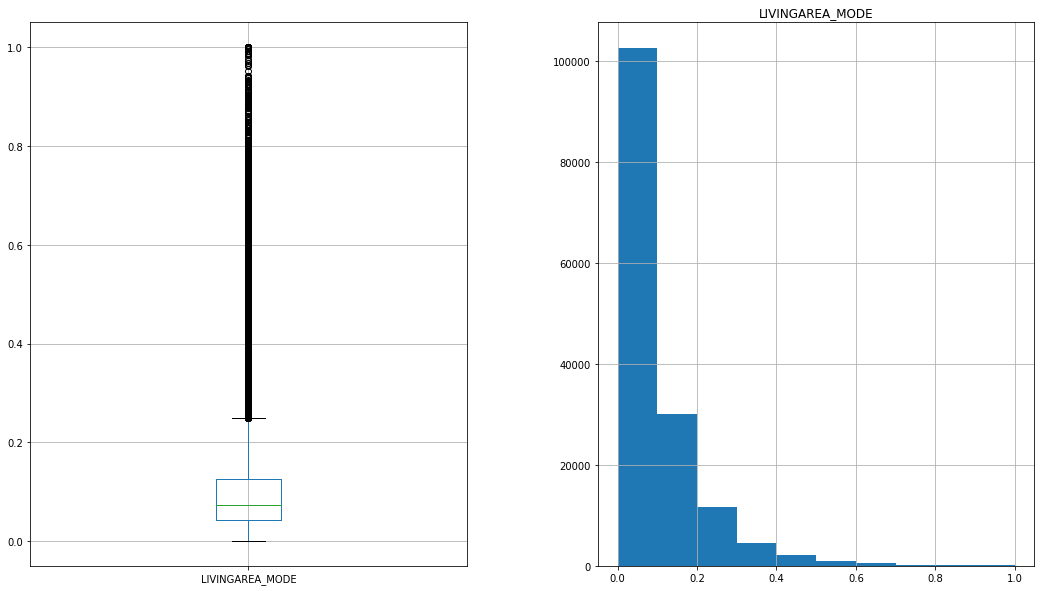

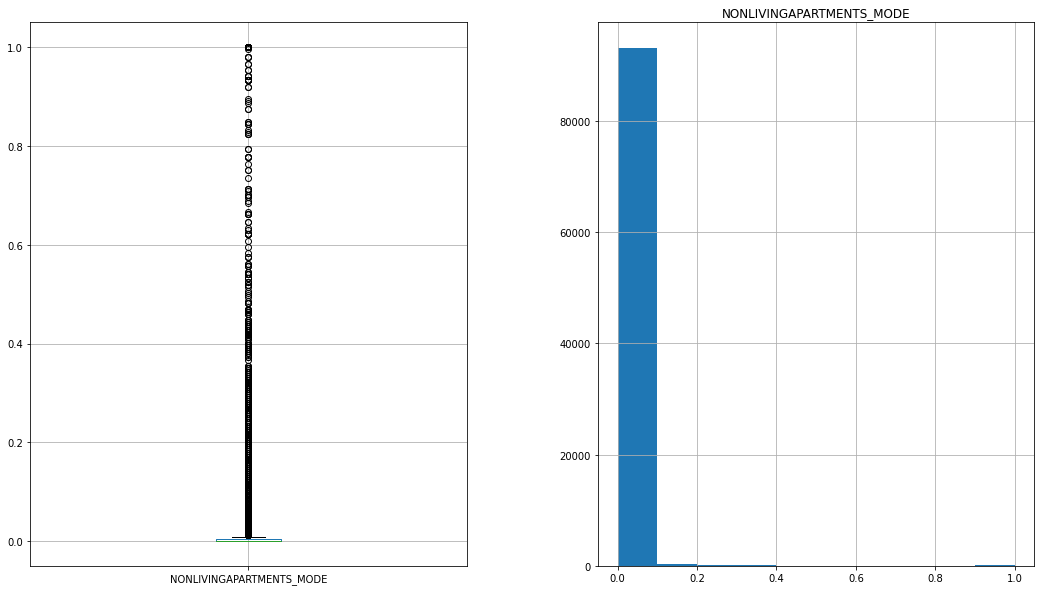

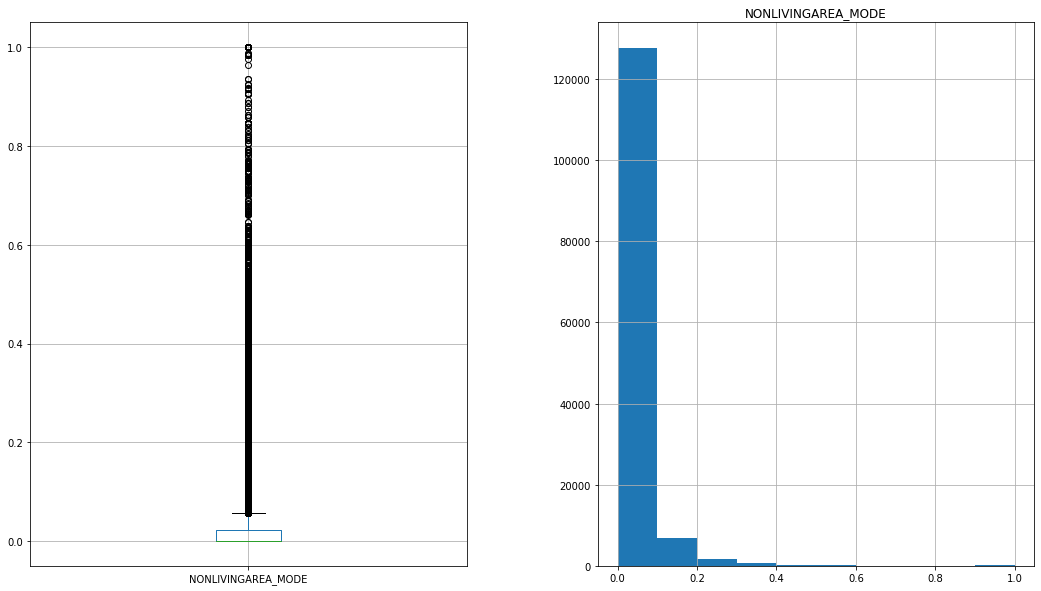

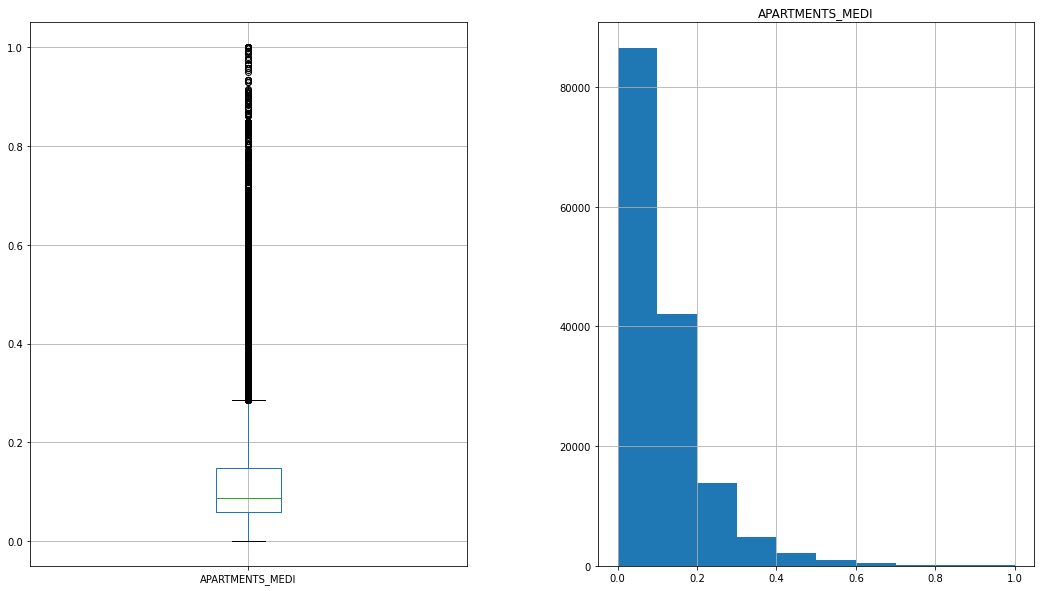

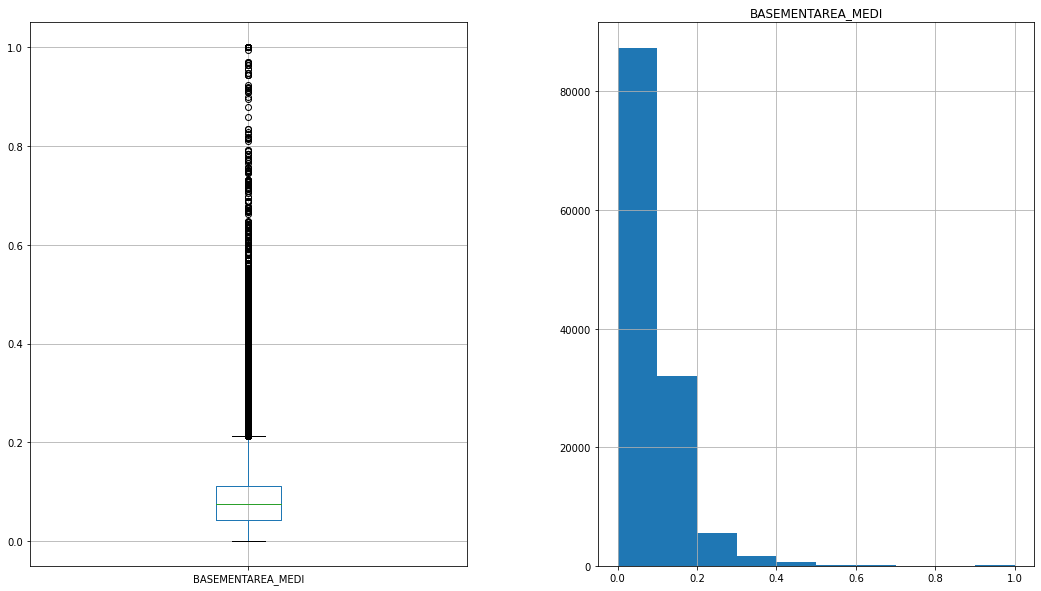

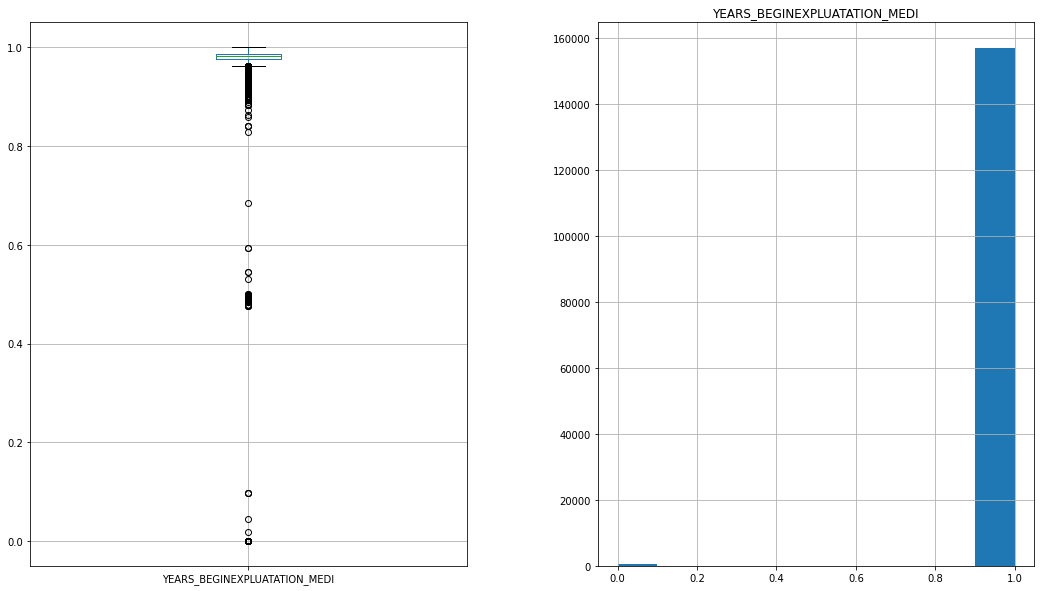

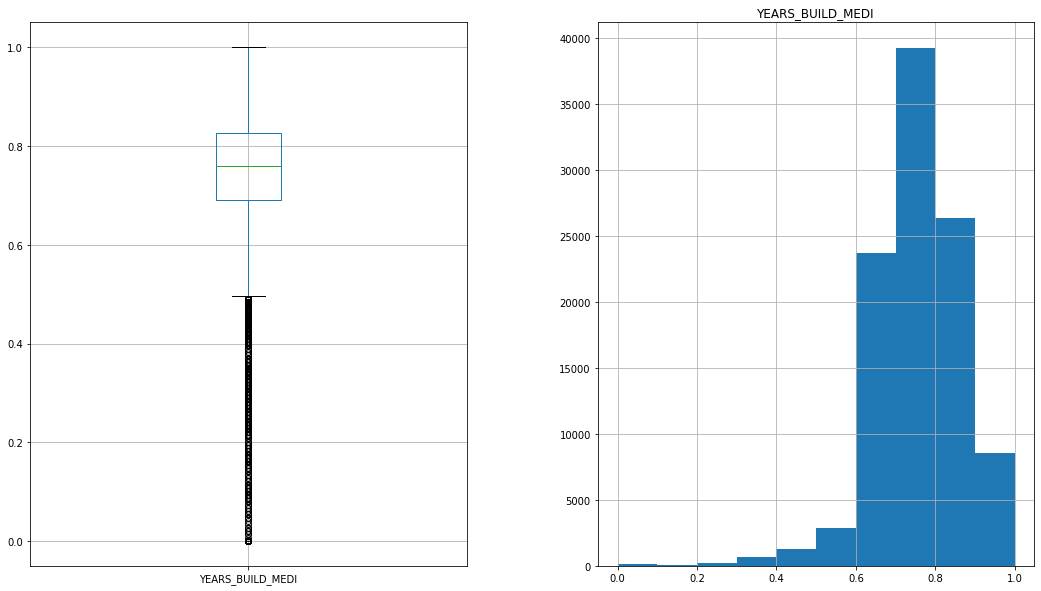

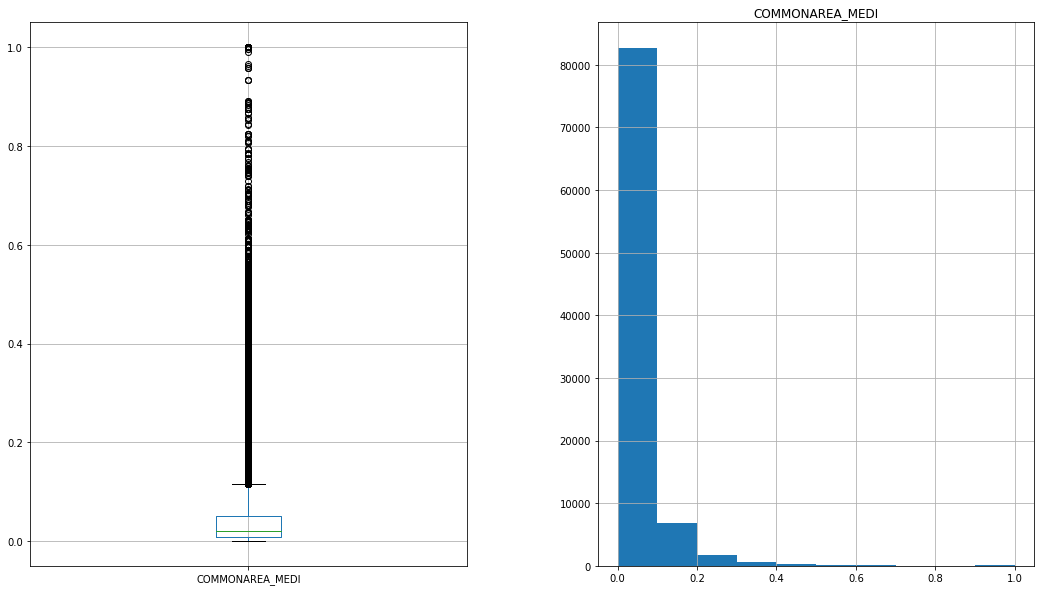

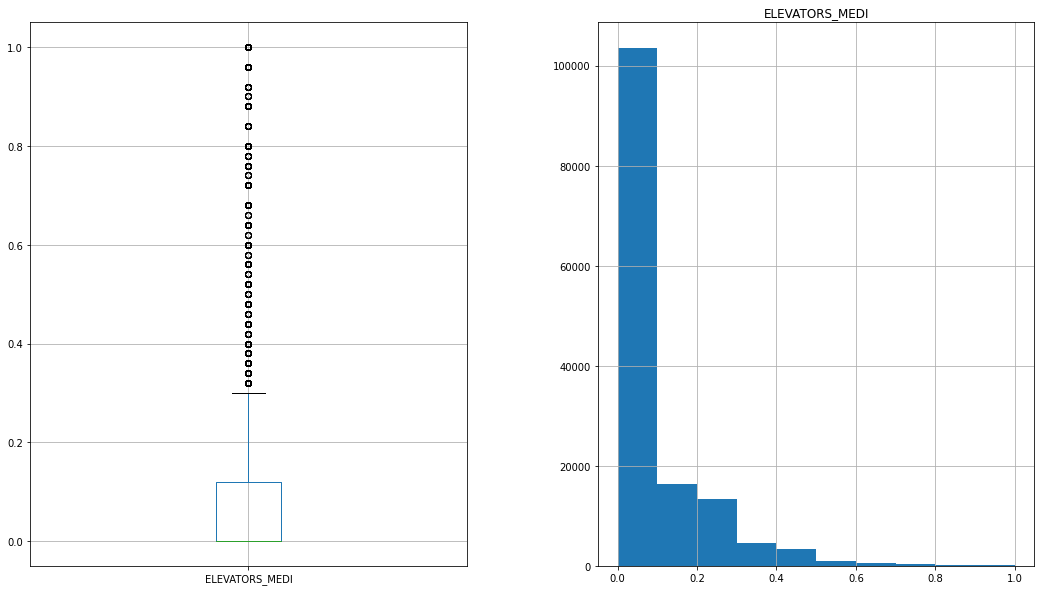

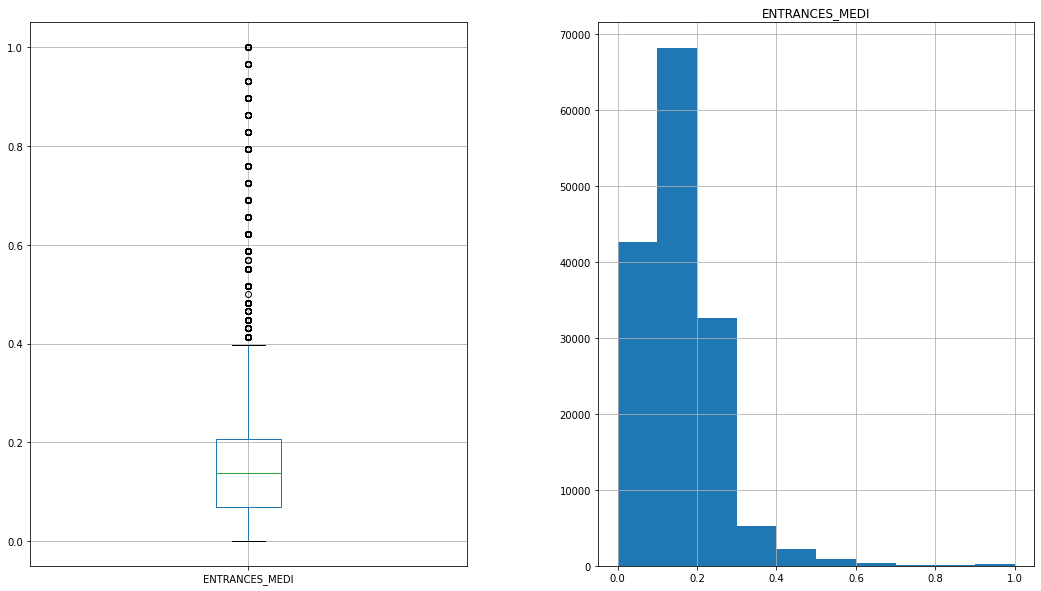

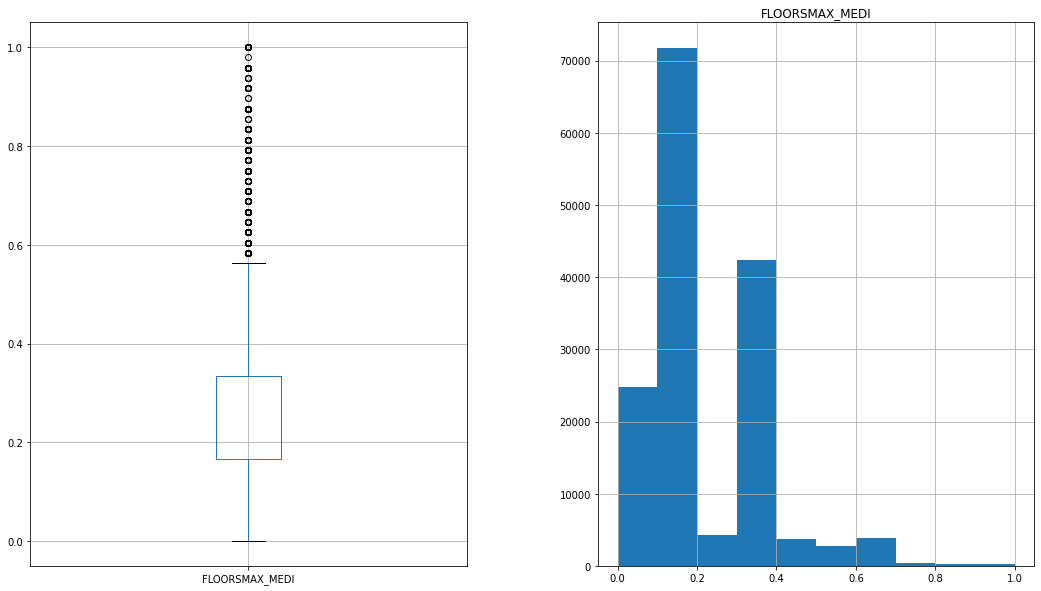

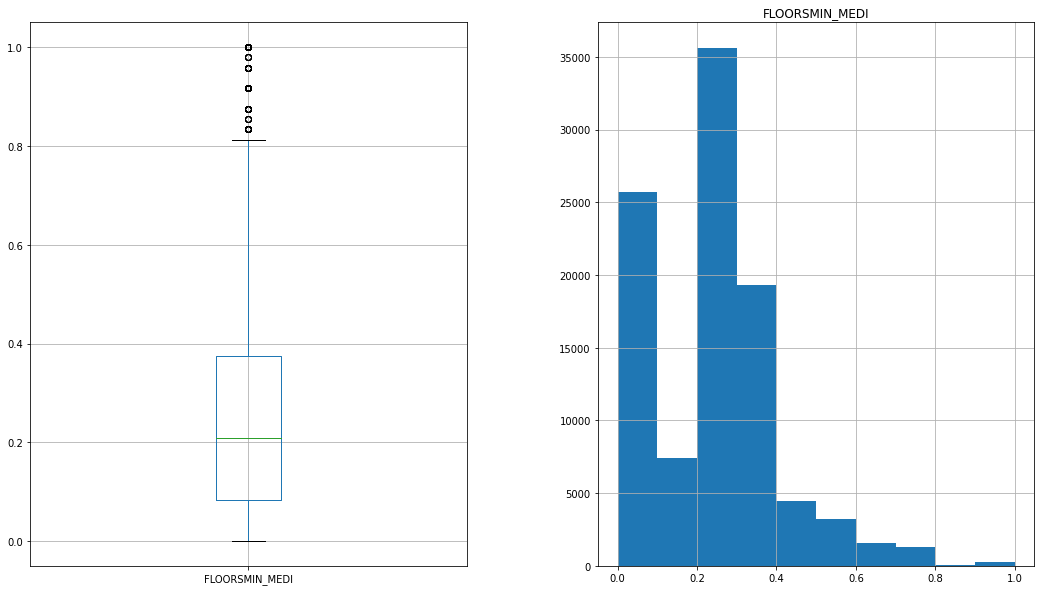

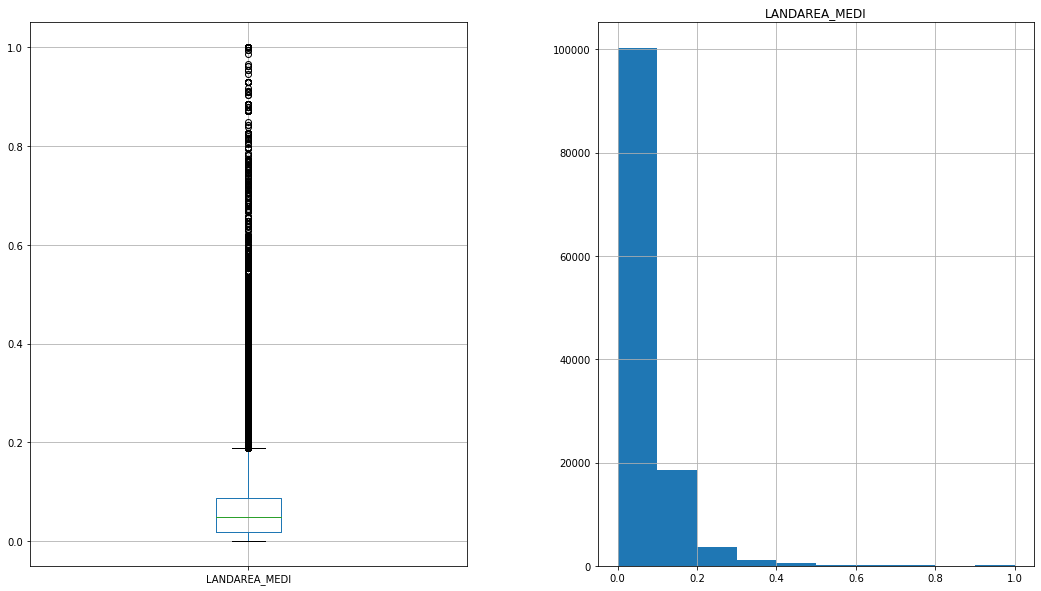

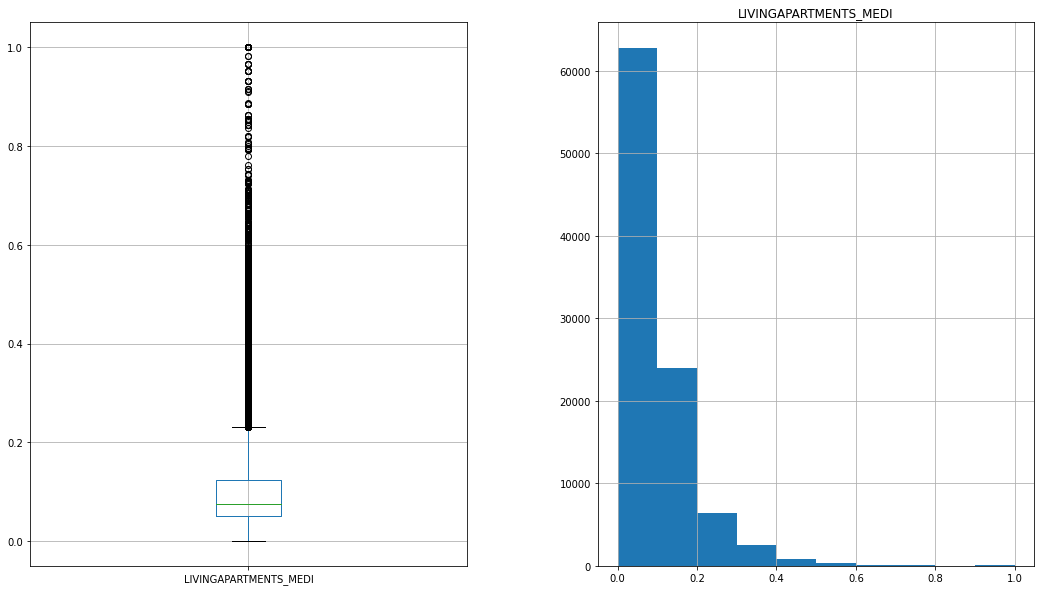

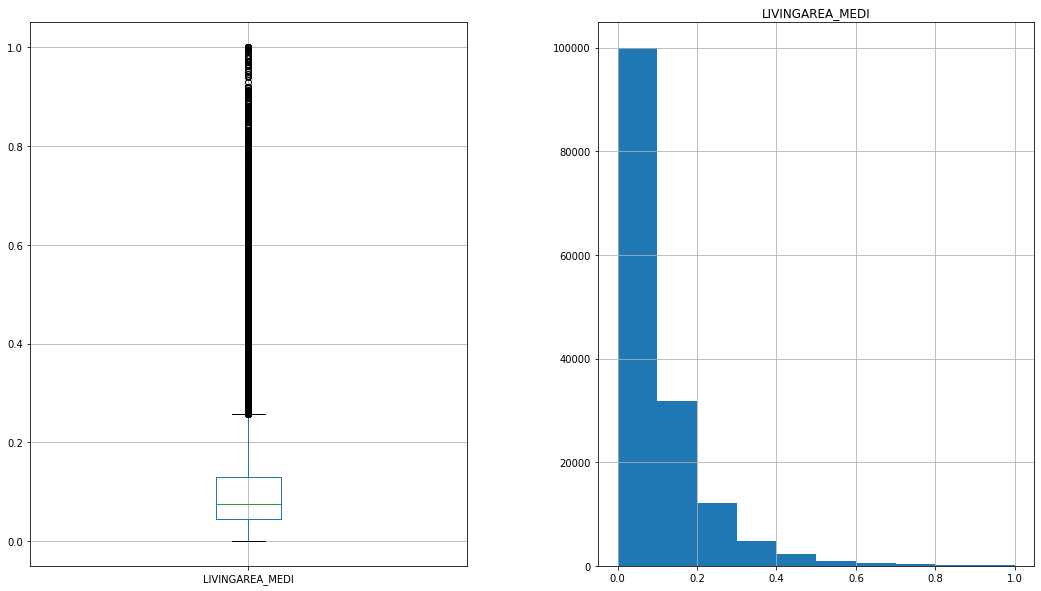

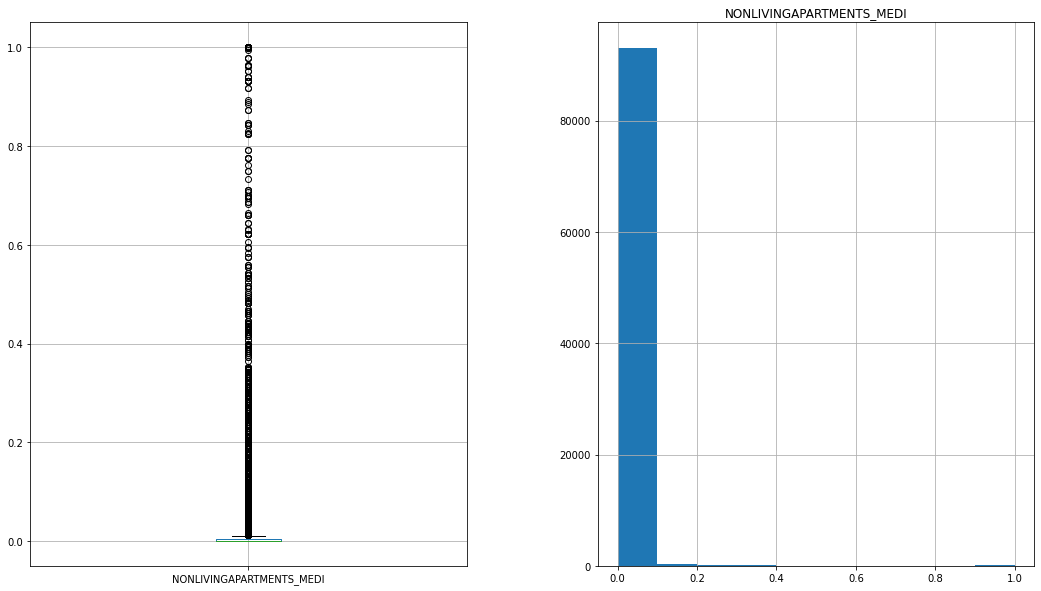

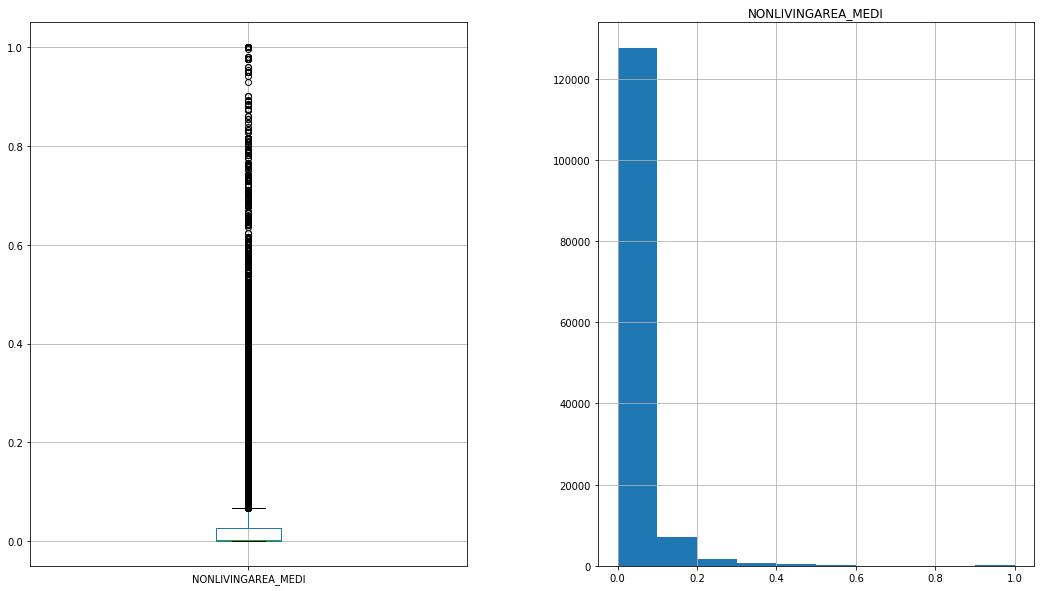

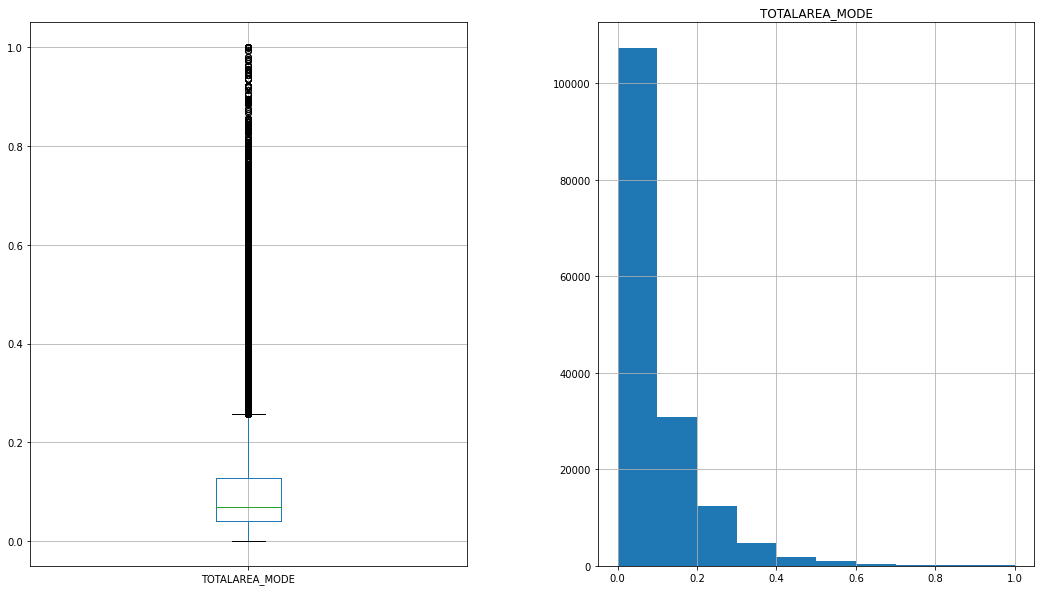

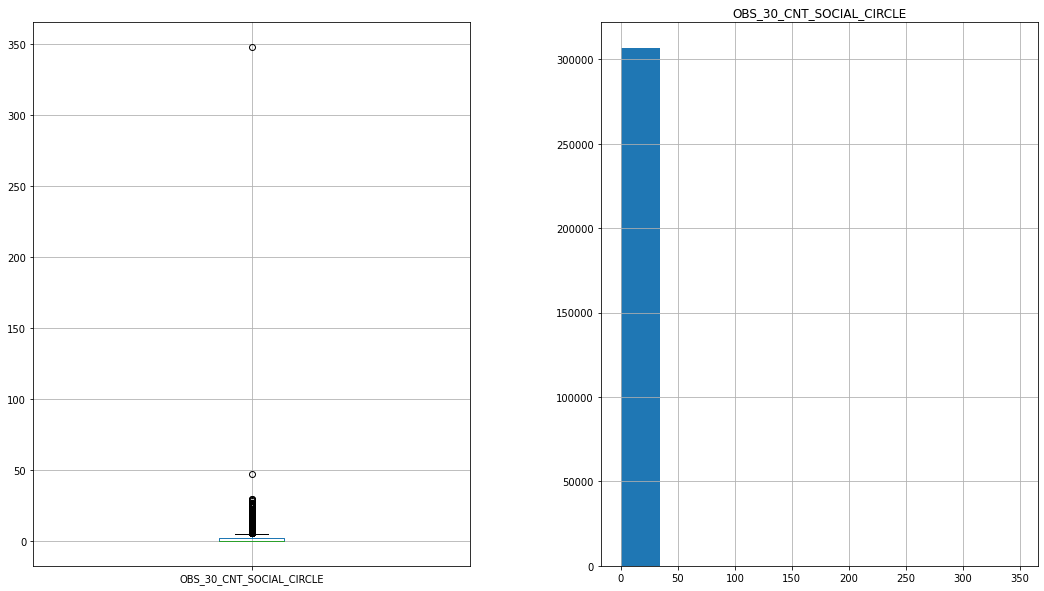

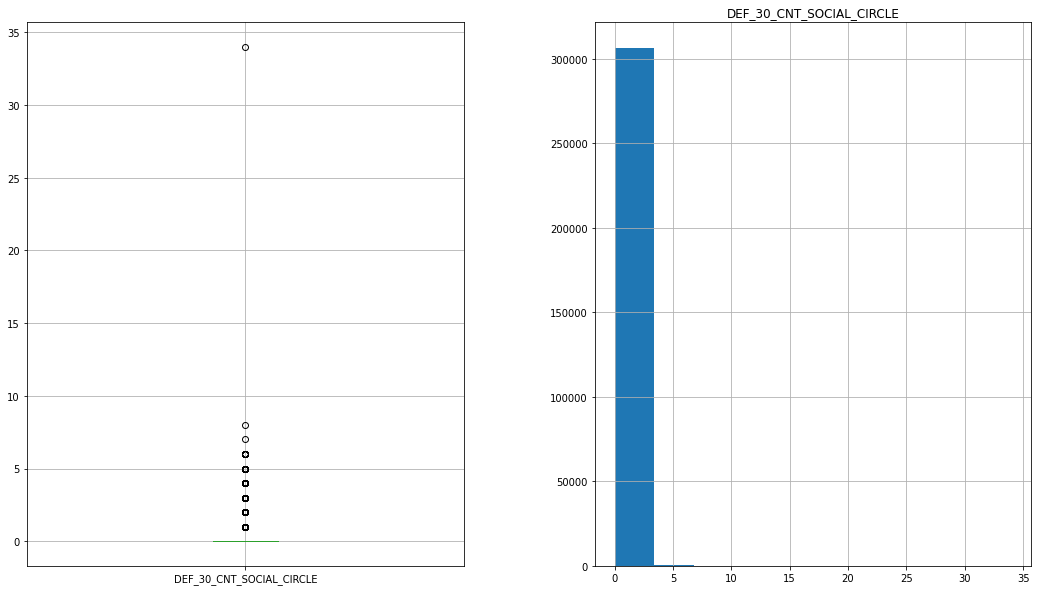

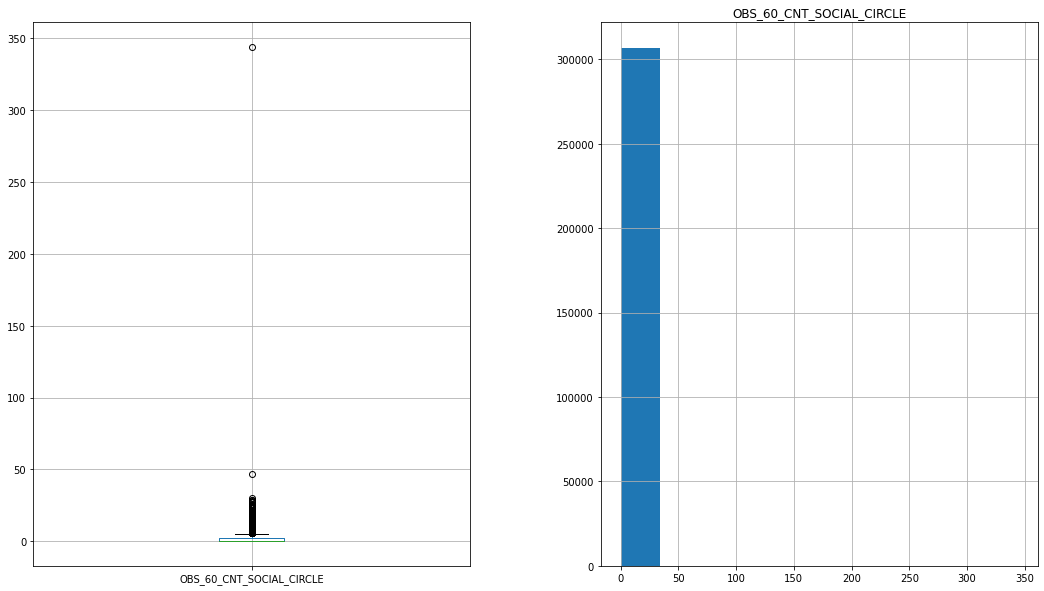

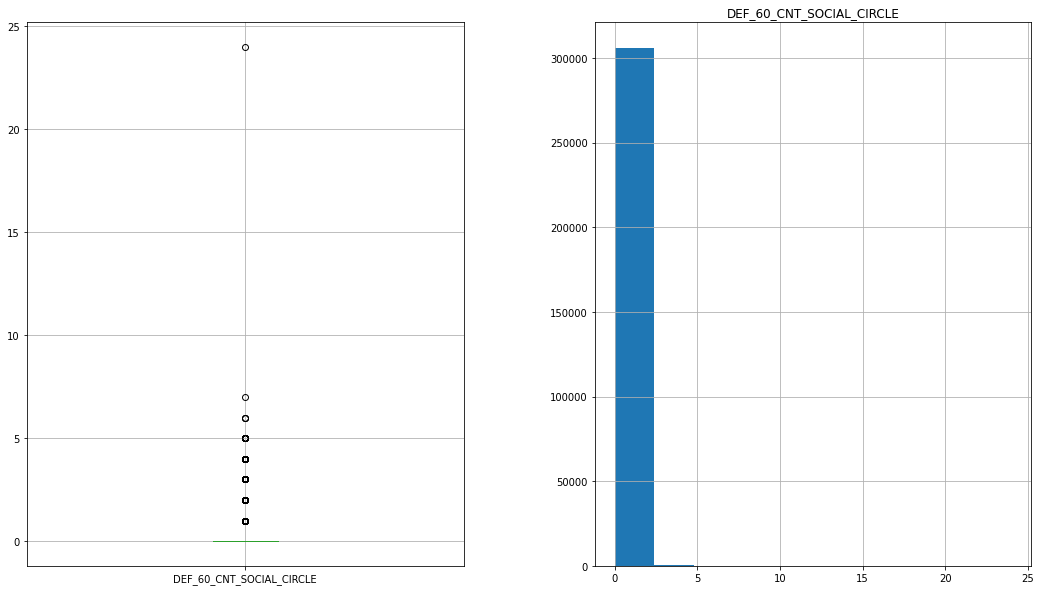

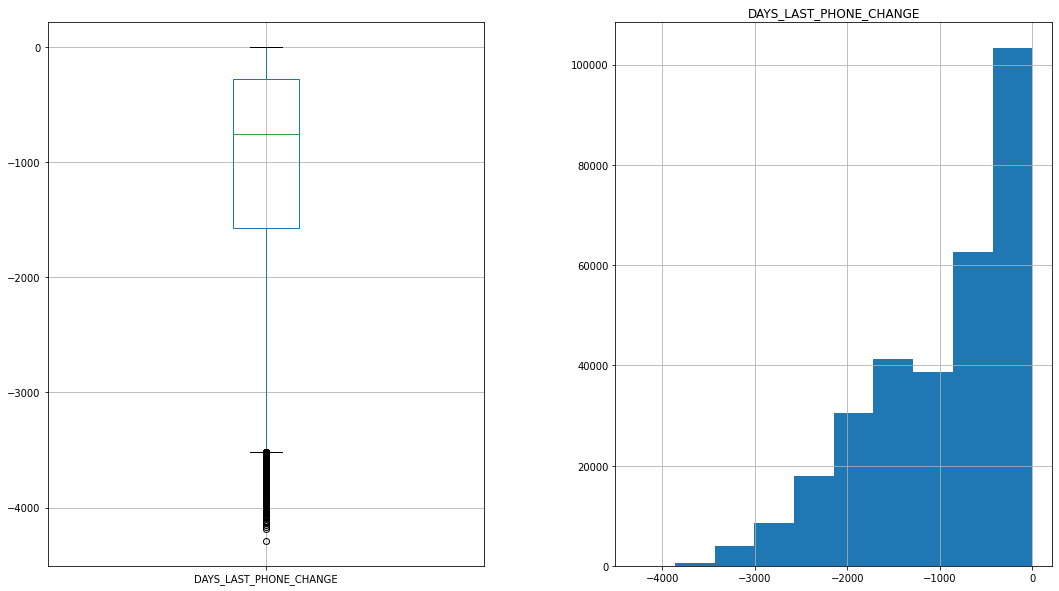

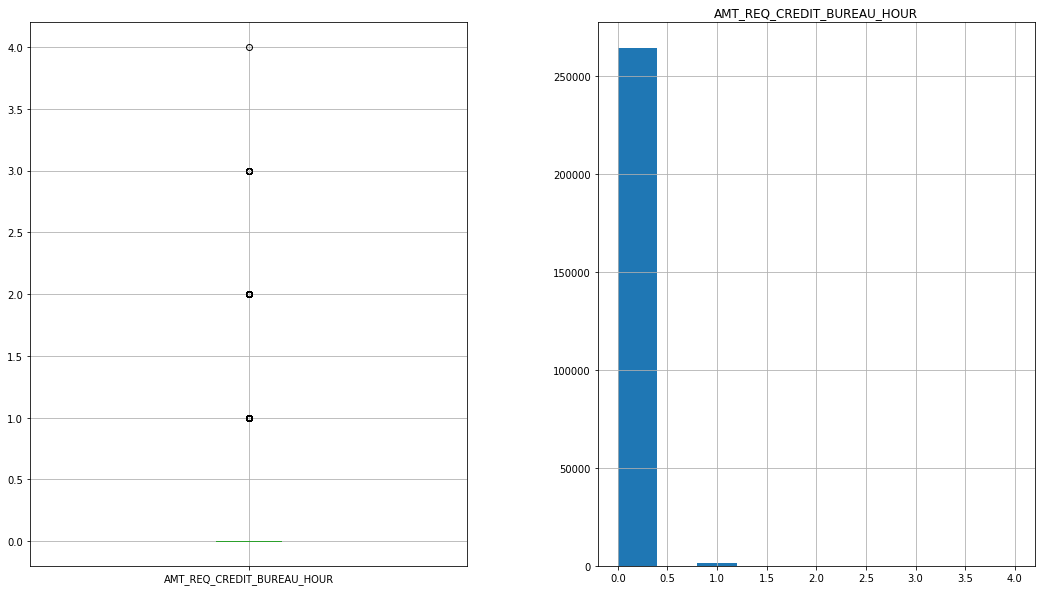

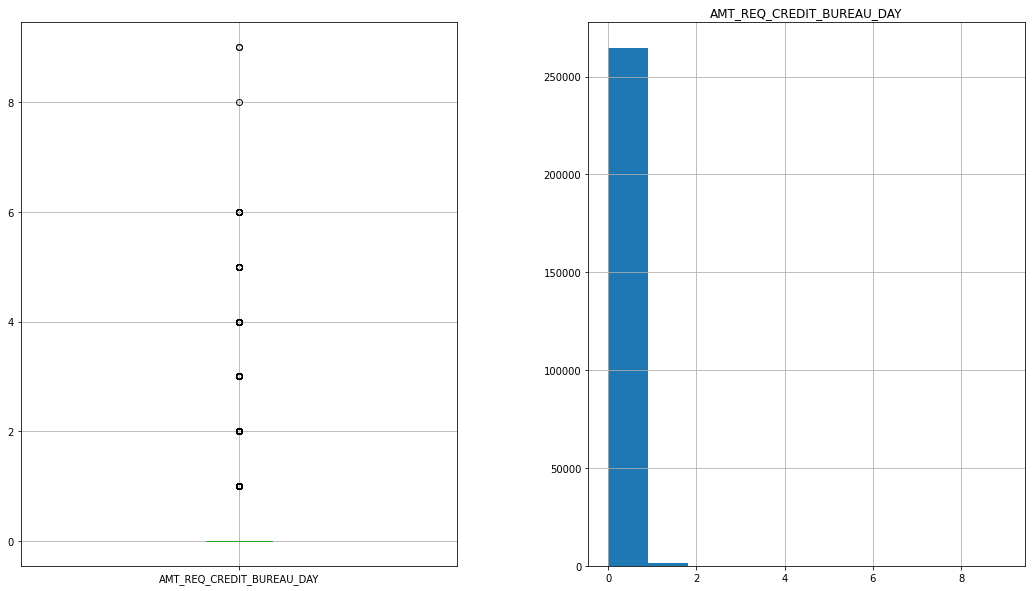

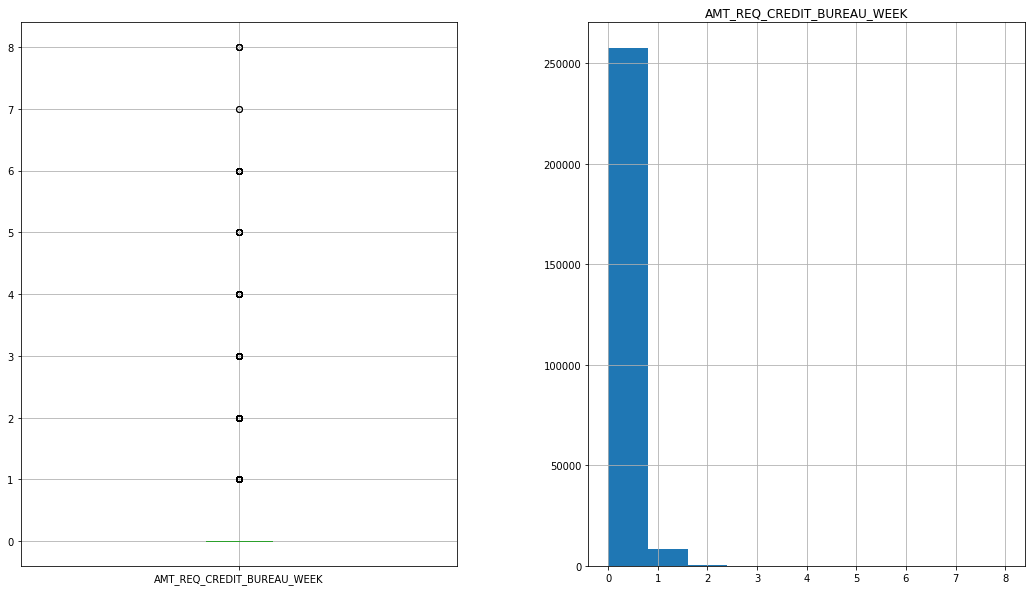

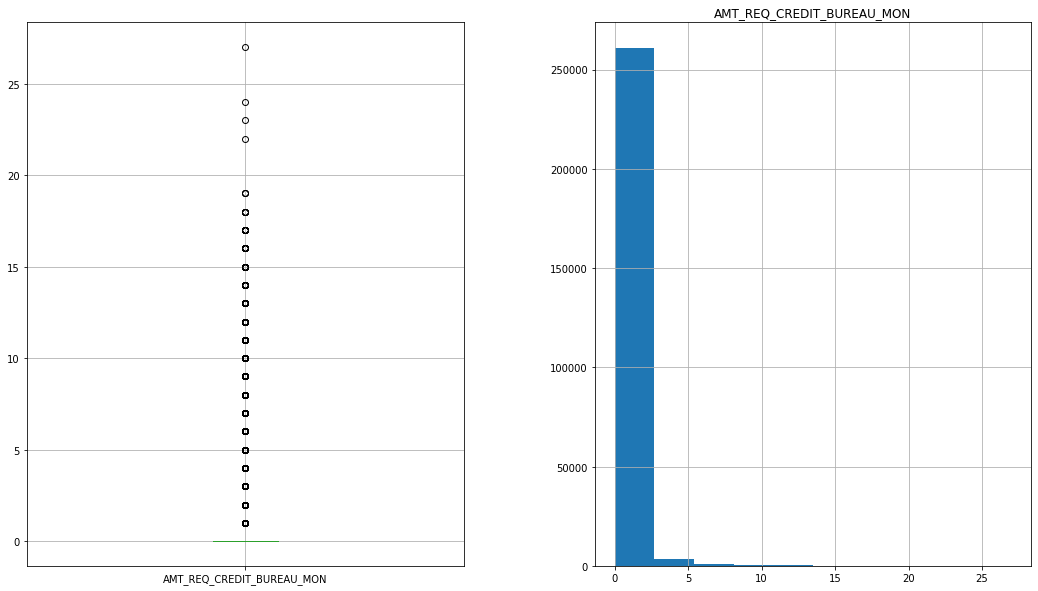

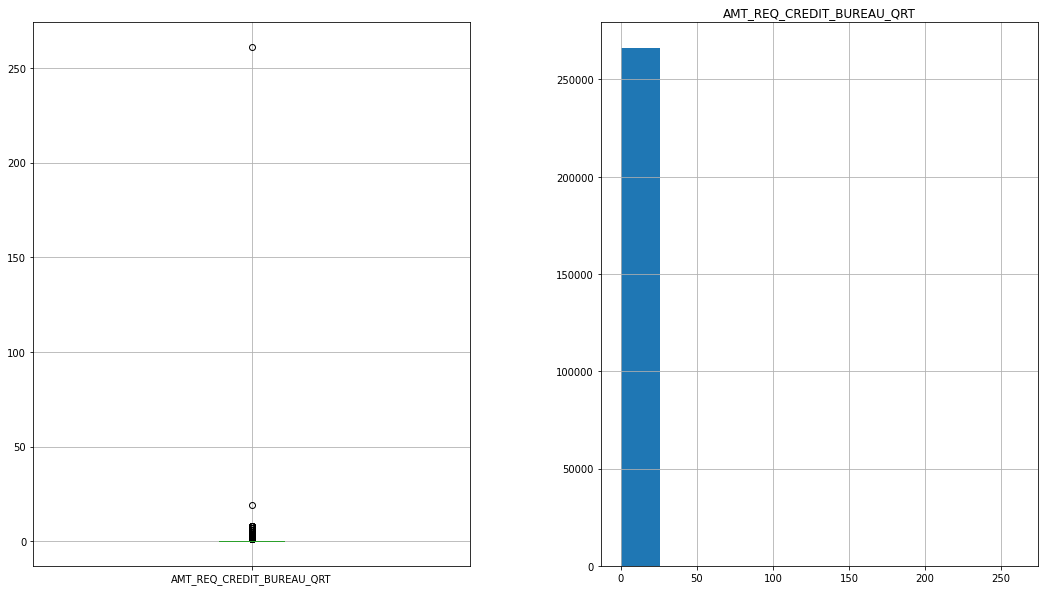

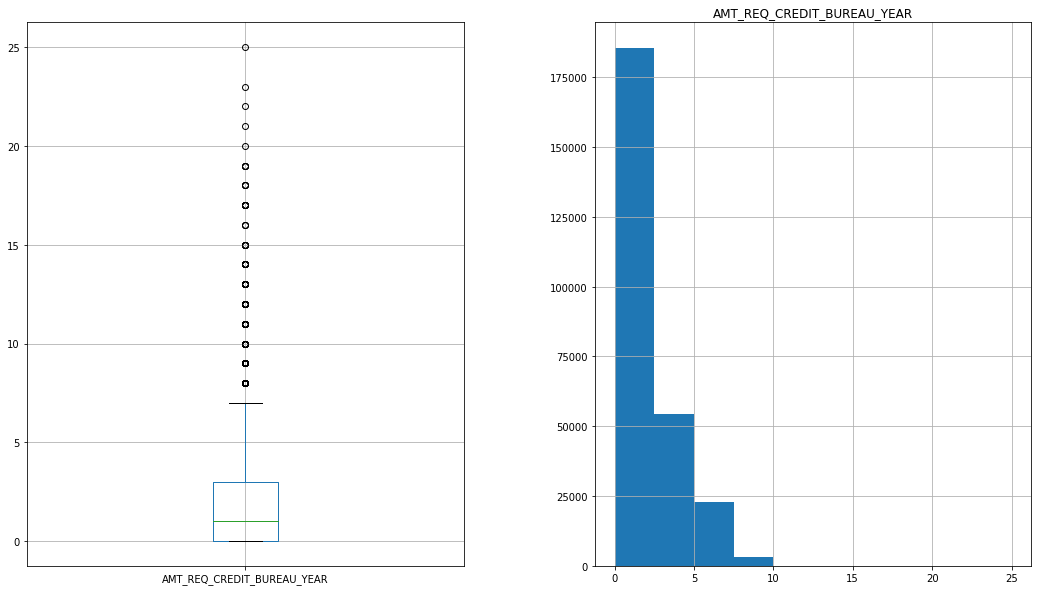

In [5]:
# 先篩選數值型的欄位

#numeric_dtype_select是用來篩選出數值型featrue的mask
dtype_select = [np.dtype("int64"),np.dtype("float64")] 
numeric_dtype_select=app_train.dtypes.isin(dtype_select)
numeric_dtype_select  #特徵為數據型=>True，反之，False

#用mask(numeric_dtype_select)篩選出數值型feature，再將feature裝成一個list
numeric_columns = list(app_train.columns[numeric_dtype_select])  #columns[mask]
numeric_columns
app_train[numeric_columns] #只剩數值型featrue

# # 再把只有 2 值 (通常是 0,1) 的欄位去掉，因為這種資料不會有離群值
app_train[numeric_columns].apply(lambda x:len(x.unique())!=2 )
filter_columns = list(app_train[numeric_columns].apply(lambda x:len(x.unique())!=2 )) #mask
numeric_columns = app_train[numeric_columns].columns[filter_columns]
numeric_columns 

#print("Numbers of remain columns" % len(numeric_columns))

# # 檢視這些欄位的數值範圍
for col in numeric_columns:
  fig=plt.figure(figsize=(18,10)) #plt.figure()設定圖的屬性，圖形寬18高10
  ax1=fig.add_subplot(121) #子圖位在1x2主圖中的位置1
  ax2=fig.add_subplot(122) #子圖位在1x2主圖中的位置2
  app_train.boxplot(column=col,ax=ax1)
  app_train.hist(column=col,ax=ax2)  
  plt.show()

In [6]:
# 從上面的圖檢查的結果，至少這三個欄位好像有點可疑

# AMT_INCOME_TOTAL
# REGION_POPULATION_RELATIVE
# OBS_60_CNT_SOCIAL_CIRCLE

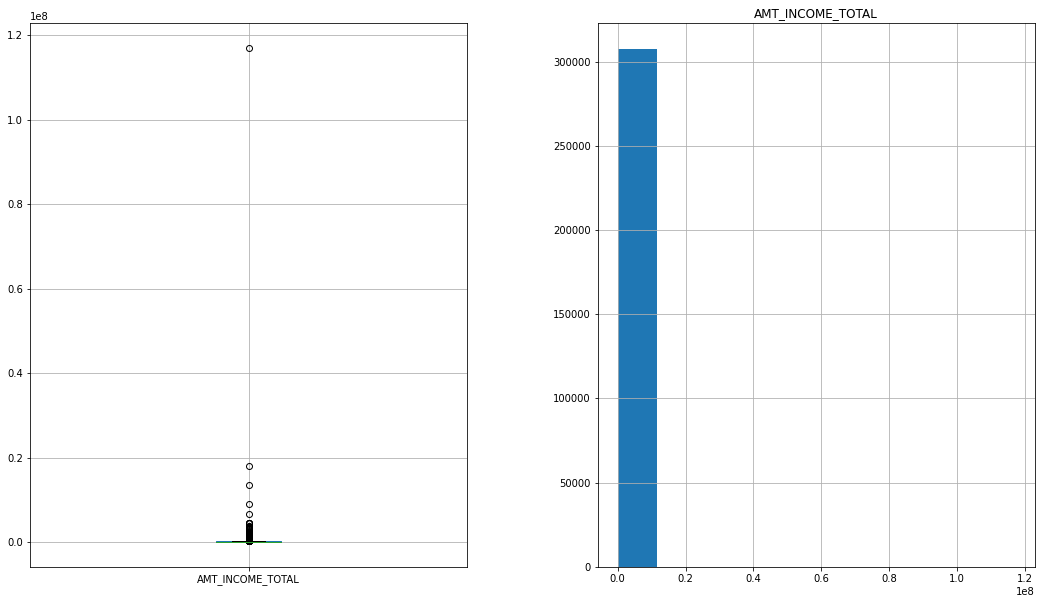

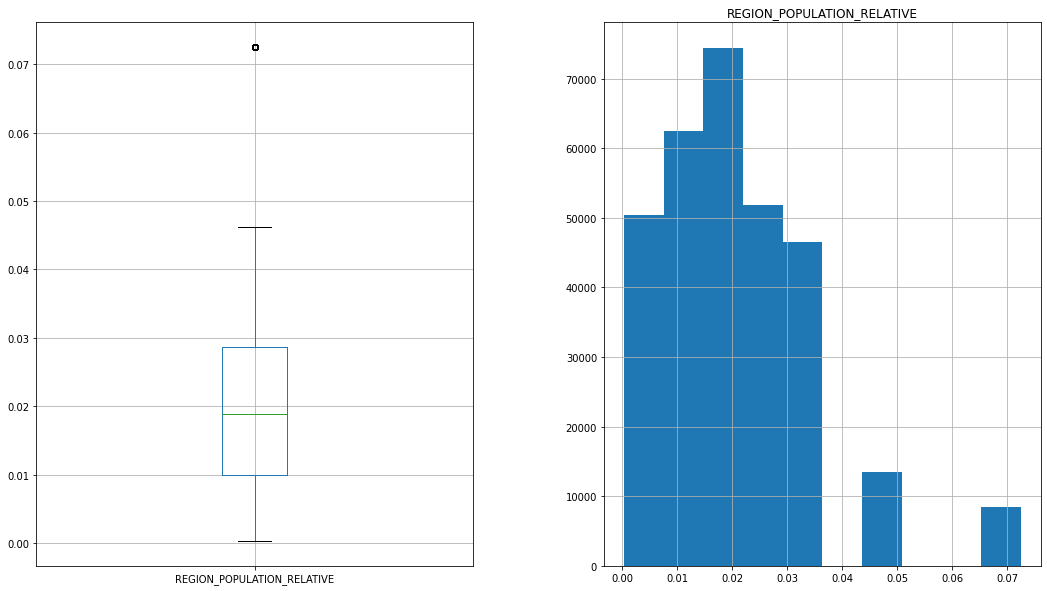

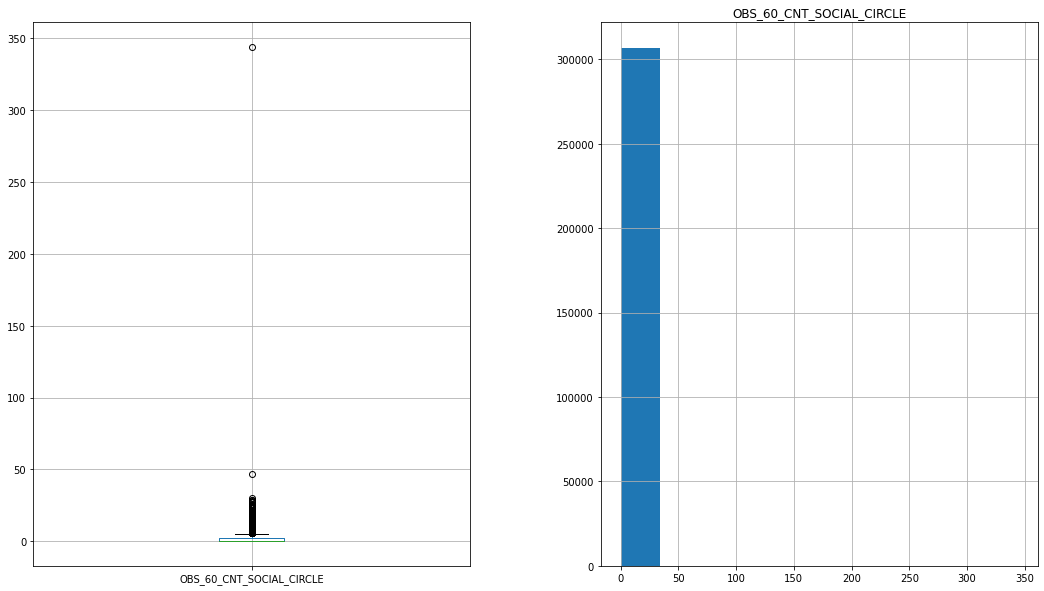

In [7]:
# 針對這3個可疑featrue畫圖
for col in ['AMT_INCOME_TOTAL','REGION_POPULATION_RELATIVE','OBS_60_CNT_SOCIAL_CIRCLE']:
  fig=plt.figure(figsize=(18,10)) #plt.figure()設定圖的屬性，圖形寬18高10
  ax1=fig.add_subplot(121) #子圖位在1x2主圖中的位置1
  ax2=fig.add_subplot(122) #子圖位在1x2主圖中的位置2
  app_train.boxplot(column=col,ax=ax1)
  app_train.hist(column=col,ax=ax2)  
  plt.show()

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
25650.0             2
26100.0             5
26460.0             6
26550.0             8
27000.0            74
                ...  
6750000.0      307507
9000000.0      307508
13500000.0     307509
18000090.0     307510
117000000.0    307511
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: int64


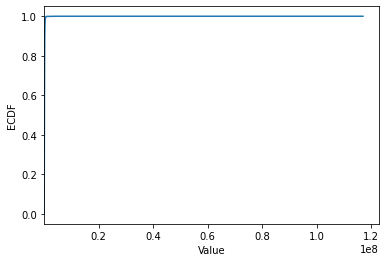

由於數據尺度的緣故，圖片無法顯現數據特性，因此將x軸數據取log做處理


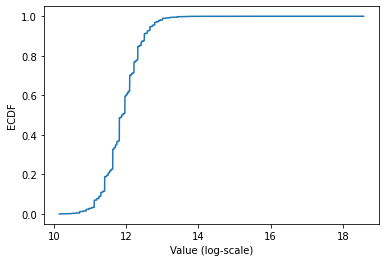

In [8]:
# 最大值離平均與中位數很遠
print(app_train['AMT_INCOME_TOTAL'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)

cdf = app_train['AMT_INCOME_TOTAL'].value_counts().sort_index().cumsum() #計算唯一值的次數，再以AMT_INCOME_TOTAL的值排序，再累積
print(cdf)

plt.plot(list(cdf.index), cdf/cdf.max()) #cdf.index:在這裡是AMT_INCOME_TOTAL的值 #cdf.max():總數量(因為"累積")
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min(), cdf.index.max() * 1.05]) # 限制顯示圖片的範圍
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()
print("由於數據尺度的緣故，圖片無法顯現數據特性，因此將x軸數據取log做處理")

# 改變 y 軸的 Scale, 讓我們可以正常檢視 ECDF
plt.plot(np.log(list(cdf.index)), cdf/cdf.max())
plt.xlabel('Value (log-scale)')
plt.ylabel('ECDF')

plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64


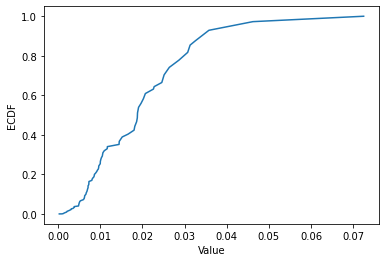

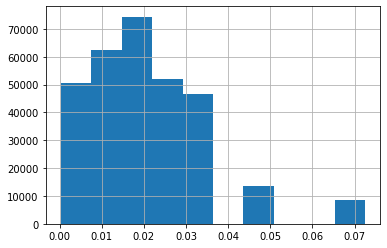

0.000290        2
0.000533       39
0.000938       28
0.001276      558
0.001333      235
            ...  
0.031329    11321
0.032561     6636
0.035792    16408
0.046220    13442
0.072508     8412
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64

In [14]:
# 最大值落在分布之外
print(app_train['REGION_POPULATION_RELATIVE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
cdf = app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index().cumsum()


plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['REGION_POPULATION_RELATIVE'].hist()
plt.show()

app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index()

# 就以這個欄位來說，雖然有資料掉在分布以外，也不算異常，僅代表這間公司在稍微熱鬧的地區有的據點較少，
# 導致 region population relative 在少的部分較為密集，但在大的部分較為疏漏

count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64


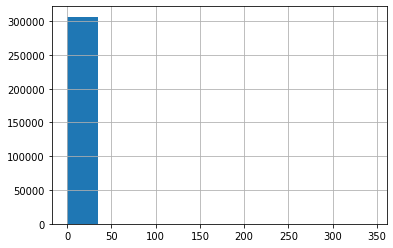

max為344，圖卻沒有顯示出來，將數據從大排到小觀察
344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64


KeyError: ignored

In [51]:
# 最大值落在分布之外
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
Your Code Here

cdf = app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index().cumsum()


plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min() * 0.95, cdf.index.max() * 1.05])
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()
"""
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()
print("max為344，圖卻沒有顯示出來，將數據從大排到小觀察")
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False))
#sort_index(ascending = True):小排到大
#sort_index(ascending = False):大排到小


## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值

<function matplotlib.pyplot.show>

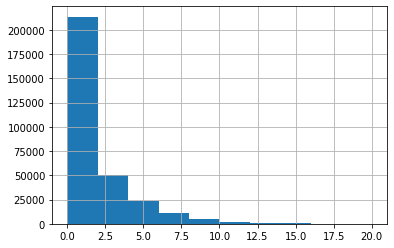

In [62]:
# 把一些極端值暫時去掉，在繪製一次 Histogram
# 選擇 OBS_60_CNT_SOCIAL_CIRCLE 小於 20 的資料點繪製

loc_a = app_train['OBS_60_CNT_SOCIAL_CIRCLE']<=20 #遮罩
loc_b = 'OBS_60_CNT_SOCIAL_CIRCLE'


app_train.loc[loc_a,loc_b].hist()
plt.show 
